*Nota:*

La interpretación de desarrollo de los procedimientos obtenidos en este notebook se encuentran formalmente presentados en formato pdf:

https://github.com/GabrielGM153/Eficiencia-y-predictivilidad-MBM


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.ardl import ardl_select_order, ARDL
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# La relación entre el IPC (Índice de Precios y Cotizaciones) con variables macroeconómicas: Actividad Económica, Inflación, Oferta Monetaria ($M_2$) y Tasa de Interés

## Contenido: 

- Una breve introducción	

- Marco teórico y revisión de la literatura	

- Metodología	

- Desarrollo

- Conclusiones

- Bibliografía	




## Una breve introducción 

### I.	Contexto y justificación del tema:

El uso de modelos econométricos y la aplicación de técnicas estadísticas ha ayudado a la sociedad mexicana al diseño de políticas económicas, al tiempo que dichos modelos y métodos dotan a los tomadores de decisiones de una perspectiva del comportamiento de variables de interés a futuro.

Actualmente, con el auge de la Ciencia de Datos, el uso de algoritmos para la resolución de problemas (en este caso problemas sociales aplicando métodos cuantitativos) y la creciente demanda de lenguajes de programación orientados a potenciar el análisis económico; se plantea una integración metodológica entre modelos econométricos y modelos propios de la ciencia de datos. 

En este trabajo, dicha integración, de primera instancia, tiene una naturaleza comparativa entre los modelos. Se buscan identificar fortalezas y debilidades dentro los modelos utilizados, para posteriormente encontrar un punto convergente adecuado al problema de investigación planteado en este documento. Una integración de este calibre no es cosa aleatoria, ya que los métodos fundamentales de la ciencia de datos descansan en los mismos métodos fundamentales usados en el análisis econométrico, esta convergencia metódica y matemática dota a los economistas de una riqueza en función a su perspectiva y arsenal de herramientas.  

La célula de este documento responde a una naturaleza predictiva (a través del trabajo de series temporales), el comportamiento del Índice de Precios y Cotizaciones (IPC), tomando cuatro variables macroeconómicas en perspectiva para la propia explicación. Las variables macroeconómicas son la actividad económica (IGAE), la tasa de interés, la oferta monetaria (M2), y la inflación. Existen distintas aplicaciones al realizar una predicción robusta del comportamiento del IPC, y encontrar propiamente el peso que tienen las variables macroeconómicas en dicho comportamiento; a saber, que sirve tanto al consumidor que busca hacer inversiones con capital propio en la BMV, tanto al productor que tiene un stock de capital y desea tener rendimientos fructíferos haciendo esta última estrategia de inversión. 

La esencia de esta investigación sirve tanto a los agentes económicos inversores como a los economistas que buscamos una integración técnica.

### II.	Planteamiento del problema

En economía aplicada, la relación que existe entre una economía real con los comportamientos decisivos que ejercen los agentes económicos, los mercados financieros, la política económica y el comportamiento de las variables macroeconómicas representa una dinámica compleja se enmarca en los debates fundamentales de las finanzas modernas, así como en los enfoques alternativos de la teoría económica.

La base teórica para el análisis univariado del Índice de Precios y Cotizaciones (IPC) es la Hipótesis del Mercado Eficiente (HME), formalizada por Fama (1970). En su forma débil, la HME postula que los precios actuales de los activos ya incorporan toda la información contenida en los datos históricos de precios. Como consecuencia, no es posible obtener rendimientos superiores de manera consistente mediante el análisis de patrones pasados. 

El corolario empírico de esta hipótesis es que los precios de los activos (o sus logaritmos) siguen una caminara aleatoria. Como explican textos de econometría de referencia como Gujarati y Porter (2010), un paseo aleatorio es una serie de tiempo no estacionaria con una raíz unitaria, cuya primera diferencia es ruido blanco. La implicación directa es que el mejor pronóstico para el precio de mañana es el precio de hoy, más una deriva aleatoria.

En contraposición a la HME, la teoría de valuación de activos argumenta que el valor intrínseco de los mercados bursátiles debe estar anclado a los fundamentos macroeconómicos de la economía real. Modelos como el Modelo de Descuento de Dividendos establecen un vínculo directo entre los precios de las acciones y dos variables clave: los flujos de efectivo futuros esperados (dividendos) y la tasa de descuento utilizada para traerlos a valor presente (Bodie, Kane, & Marcus, 2018).

Este enfoque justifica el uso de modelos multivariados (como el Modelo Autorregresivo de Rezagos Distribuidos) para buscar relaciones de cointegración, un concepto desarrollado por Engle y Granger (1987), que sugiere que, aunque las series puedan ser paseos aleatorios individualmente, están ligadas por un equilibrio a largo plazo dictado por la teoría económica.

Por otro lado, la dinámica de los mercados financieros es inherentemente compleja, caracterizada por cambios de régimen, efectos de retroalimentación y comportamiento adaptativo de los agentes. Esto sugiere que las relaciones entre las variables macroeconómicas y el IPC pueden ser no lineales (McMillan, 2001).

Esta posible no linealidad justifica la aplicación de modelos de Machine Learning. Algoritmos como XGBoost o redes neuronales LSTM son estimadores universales de funciones, capaces de capturar patrones complejos y no lineales sin que el investigador deba especificarlos a priori. Su superioridad predictiva sobre los modelos lineales, obtenida en numerosos estudios empíricos (Henrique, Sobreiro, & Kimura, 2019), puede ser interpretada como evidencia de la existencia de estas dinámicas no lineales en los datos.


### III.	Objetivos e hipótesis

a)	Objetivo general: Analizar y comparar la capacidad de los modelos econométricos (ARIMA y Modelo Autorregresivo de Rezagos Distribuidos), de Machine Learning (XGBoost y Random Forest) y un modelo de redes perteneciente al aprendizaje profundo LSTM (Long Short-Term Memory) para explicar y pronosticar el comportamiento del Índice de Precios y Cotizaciones de la Bolsa Mexicana de Valores, utilizando un conjunto de variables macroeconómicas clave.

b)	Objetivos específicos:
•	Analizar las propiedades de las series de tiempo, determinando el orden de integración del IPC y de las variables macroeconómicas (IGAE, M2, inflación, tasa de interés) mediante pruebas de raíz unitaria de Dickey-Fuller Aumentada.

•	Construir un modelo ARIMA univariado para el IPC como un modelo de referencia que represente la Hipótesis del Mercado Eficiente en su forma débil.

•	Implementar un modelo  autorregresivo de rezagos distribuidos multivariado para investigar la existencia de una relación de cointegración de largo plazo entre el IPC y al menos una de las variables macroeconómicas, así como estudiar una relación que corresponda al corto plazo.

•	Entrenar y evaluar modelos de Machine Learning (XGBoost y Random Forest) y el modelo de Aprendizaje Profundo (LSTM) para pronosticar el IPC, capturando posibles relaciones no lineales y dinámicas temporales complejas.

•	Comparar el desempeño predictivo de todos los modelos a través de métricas de error (como RMSE y MAE), para concluir qué enfoque metodológico ofrece el pronóstico más preciso para el mercado bursátil mexicano en el horizonte de estudio.

•	Hacer una comparativa entre modelos de análisis y el comportamiento real del IPC.

c)	Hipótesis:

•	La variable oferta monetaria es el principal componente en cuanto al comportamiento del IPC.

•	Los resultados que se obtienen cuando se usan métodos econométricos, contrastados con la metodología de la ciencia de datos, puede divergir por la misma naturaleza metodológica que le es propia a las dos áreas. Y en este sentido, el planteamiento resulta ser un periplo metodológico, ya que en primer lugar se planteó la relevancia de la oferta monetaria M2, bajo un principio de causalidad y de explicación con respecto al comportamiento del IPC.

•	Y por el otro lado, a la Ciencia de Datos le compete una calidad únicamente predictiva, y es por tal motivo que se contrastan los resultados ente estas dos grandes perspectivas. 

•	Teniendo el punto anterior en cuenta, se enuncia que el modelo ARIMA es el modelo más conveniente para predecir el comportamiento del IPC con respecto a otros modelos.

### IV.	Alcances y limitaciones

1.	Selección de Variables: El análisis no considera otras variables que podrían influir en el IPC, como factores políticos, flujos de capital extranjero o el desempeño de mercados internacionales, lo que podría generar un sesgo de variable omitida.

2.	Interpretabilidad de modelos: Mientras que los modelos econométricos ofrecen coeficientes directamente interpretables en términos económicos, los modelos de Machine Learning y de Aprendizaje Profundo actúan como una especie de cajas negras, dificultando la extracción de implicaciones de política económica directas a partir de sus parámetros internos.

3.	Frecuencia de Datos: El uso de datos mensuales suaviza la volatilidad diaria y semanal, por lo que las conclusiones no aplican a estrategias de inversión de alta frecuencia.
Marco teórico y revisión de la literatura

###	Conceptos clave y definiciones

#### **Sobre el Índice de Precios y Cotizaciones**

El IPC es el principal indicador bursátil que se tiene dentro la Bolsa Mexicana de valores, este mide la variación los precios de las acciones con mayor liquidez y mejor capitalización dentro del mercado mexicano. La utilización de este indicador en este trabajo es importante y con gran relación a los objetivos de estudio, ya que, en general, si el IPC sube, en promedio las acciones que lo componen han aumentado de valor; si baja, el mercado ha perdido valor. Es por tal motivo que este documento es de interés para los agentes económicos que toman decisiones de inversión. 

En términos de análisis, en el IPC se pueden identificar los ciclos, tendencias y volatilidad que le corresponden, a raíz de estos elementos, es que los economistas podemos estimar modelos predictivos con ayuda de modelos econométricos, y como principal interés a esta investigación, ayudar al análisis de datos en series temporales con modelos propios de la Ciencia de Datos. 

Además, de que de acuerdo con el trabajo del profesor Hernández Mota, J. L. (2015), el sistema no es solamente una variable explicativa del desempeño económico, sino que es un factor productivo fundamental que puede tener efectos permanentes sobre la tasa de crecimiento de una economía. 


#### **Modelo ARIMA**

Este modelo autorregresivo de medias móviles es angular en el desarrollo de este documento, porque, además de formar parte de una de las hipótesis planteadas, este es uno de los modelos más utilizados y enseñados para el trabajo con este tipo de datos.

Gujarati, D. N., & Porter, D. C. (2010) especifican a este modelo como ARIMA (p, d, q), componiéndose este de tres componentes: 

•	Su componente autorregresivo AR(p) que asume que la serie temporal depende linealmente de sus componentes pasados, en este caso específico, que el IPC depende linealmente de sus valores en el pasado. Este componente en cuestión tiene la estructura: 

**Ecuación AR(p):**

$$
Y_t = c + \Phi_1 Y_{t-1} + \Phi_2 Y_{t-2} + \cdots + \Phi_p Y_{t-p} + u_t
$$


- **$Y_{t-p}$:** Son los valores que adopta la serie en periodos anteriores.  
- **$\Phi_p$:** Representa los coeficientes que miden el impacto de cada rezago en el valor actual de la serie temporal.  
- **$c$:** Es la constante del modelo.  
- **$u_t$:** Es el término de error estocástico.  

•	Componente integrado I(d): Que es el componente que se encarga de hacer que los datos sean estacionarios, y evitar que el análisis sea nulo, por motivos de correr una regresión espuria. El parámetro descrito como I(d) indica el número de veces que la serie se diferenció, hasta alcanzar la estacionariedad. 

•	Componente de media móvil MA(q): Que se refiere a que el valor que se obtiene en la serie actual depende de los errores pronosticados en los periodos anteriores, o sea, el parámetro descrito como MA(q) indica cuantos errores rezagados se incluyen en el modelo. En otras palabras, este componente del modelo captura los efectos aleatorios en el corto plazo. Su estructura corresponde a la siguiente:

**Ecuación MA(q):**

$$
Y_t = \mu + u_t + \theta_1 u_{t-1} + \theta_2 u_{t-2} + \cdots + \theta_q u_{t-q}
$$


Dónde:  
- **$\mu$:** Es la media de la serie temporal.  
- **$u_t$:** Es el error estocástico.  
- **$\theta_q$:** Son los coeficientes que miden el impacto de los errores pasados en el modelo.  



#### **Modelo Aurorregresivo de Rezagos Distribuidos**

La justificación del uso de este modelo en el presente análisis, y teniendo en perspectiva el trabajo de Nkoro, E., & Uko, A. K. (2016), radica en su capacidad para estudiar las relaciones dinámicas que existen en las series de tiempo tanto en el corto plazo, como en el largo plazo. En este caso, la motivación principal es encontrar una relación que tenga una función explicativa en el comportamiento el IPC. 

Siguiendo a los autores citados en el párrafo anterior, un Modelo Autorregresivo de Rezagos Distribuidos nos permite llegar a estos objetivos planteados a partir de la determinación de la cointegración, al tiempo que se analiza el o los impactos en el corto y en el largo plazo por parte de la una de las variables macroeconómicas (dentro del análisis se hace la selección de la variable más óptima) para con el IPC. 

La estructura matemática del modelo tiene la siguiente forma: 

**Ecuación ARDL (Autoregressive Distributed Lag):**

$$
Y_t = \beta_0 + \sum_{i=1}^{p} \phi_i Y_{t-i} + \sum_{j=0}^{q} \delta_j X_{t-j} + u_t
$$

Dónde:  
- **$Y_{t-i}$:** Son los rezagos de la variable dependiente.  
- **$X_{t-j}$:** Son los rezagos de la variable independiente.  
- **$p \land q$:** Son los números de rezagos óptimos.  
- **$\phi \land \delta$:** Son coeficientes por estimar.  
- **$u_t$:** Es el error estocástico.  

Nkoro, E., & Uko, A. K. (2016) señalan una robustez y flexibilidad en la práctica de este modelo, incluso en muestras pequeñas, estos motivos refuerzan la necesidad de su uso en este documento.

### Capítulo 3: Metodología

**Estadística descriptiva y exploración de datos**

**Métodos econométricos:**

- Modelo ARIMA para trabajar series temporales univariantes (benchmark).

- Modelo Autorregresivo de Rezagos Distribuidos (orientado en el corto y largo plazo)

**Machine Learning:**

- Random Forest → relaciones no lineales.

- XGBoost → mejora en precisión predictiva.

**Deep Learning**

- Modelo LSTM 

In [2]:
#Cargamos los datos y los trabajamos como serie de tiempo:

data = pd.read_excel('C:/Users/gabri/OneDrive/Tesina/variables limpias .xlsx', index_col=[0], parse_dates=[0])


In [3]:
# Nos aseguramos de que el índice es de tipo fecha, especificando el formato
data.index = pd.to_datetime(data.index, format='%b %d, %Y')

# Ordenamos de más antiguo a más reciente
data.sort_index(ascending=True, inplace=True)

# Filtramos el rango de fechas
data = data.loc['2010-01':'2023-05']
data

,Open,High,Low,Close,Adj Close,Volume,Inflación,Oferta monetaria(M2),IGAE Serie desestacionalizada,Tasa de interés promedio mensual,Ln_Adj_close
Date,,,,,,,,,,,
2010-01-01,32120.74,33080.05,30082.77,30391.61,30391.61,3905039400,1.09,4.081855e+09,89.7876,4.91,10.321922
2010-02-01,30416.64,32283.14,29926.06,31634.54,31634.54,3097247600,0.58,4.094608e+09,90.1886,4.92,10.362005
2010-03-01,31637.89,33589.09,31637.89,33266.43,33266.43,3675413700,0.71,4.032745e+09,90.8336,4.92,10.412304
2010-04-01,33267.47,34223.87,32385.09,32687.32,32687.32,3738004700,-0.32,4.019685e+09,91.6445,4.94,10.394743
2010-05-01,32692.67,32974.68,30074.06,32038.53,32038.53,4636273400,-0.63,4.093547e+09,91.5642,4.94,10.374695
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,48506.04,55309.97,48478.94,54564.27,54564.27,2793205500,0.68,1.235475e+10,114.0758,10.78,10.907135
2023-02-01,54555.91,55173.58,52141.14,52758.06,52758.06,3428245600,0.56,1.234473e+10,114.2686,11.10,10.873472
2023-03-01,52720.40,54604.07,51814.68,53904.00,53904.00,4321742400,0.27,1.242759e+10,114.0644,11.34,10.894960


In [4]:
data.info() # vemos que tenemos datos desde 2003 hasta 2023, mensuales y sin valores nulos

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2010-01-01 to 2023-05-01
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Open                              161 non-null    float64
 1   High                              161 non-null    float64
 2   Low                               161 non-null    float64
 3   Close                             161 non-null    float64
 4   Adj Close                         161 non-null    float64
 5   Volume                            161 non-null    int64  
 6   Inflación                         161 non-null    float64
 7   Oferta monetaria(M2)              161 non-null    float64
 8   IGAE Serie desestacionalizada     161 non-null    float64
 9   Tasa de interés promedio mensual  161 non-null    float64
 10  Ln_Adj_close                      161 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 15.1 KB


#### Estadística descriptiva y exploración de datos

In [5]:
#Vamos a  comenzar el análisis haciendo un resumen estadístico de las variables:
data.describe()


,Open,High,Low,Close,Adj Close,Volume,Inflación,Oferta monetaria(M2),IGAE Serie desestacionalizada,Tasa de interés promedio mensual,Ln_Adj_close
count,161.000000,161.000000,161.000000,161.000000,161.000000,1.610000e+02,161.000000,1.610000e+02,161.000000,161.000000,161.000000
mean,43380.161242,44816.179441,41936.480559,43484.979814,43484.979814,3.967616e+09,0.361118,7.591898e+09,105.129150,5.695031,10.671543
std,5676.173936,5722.038146,5593.926727,5638.865855,5638.865855,8.381806e+08,0.383733,2.461848e+09,7.158947,2.007082,0.133040
min,30416.640000,32283.140000,29926.060000,30391.610000,30391.610000,2.487696e+09,-1.010000,4.019685e+09,87.696300,3.290000,10.321922
25%,39523.320000,41167.300000,38062.140000,40185.230000,40185.230000,3.405985e+09,0.170000,5.326722e+09,99.584200,4.320000,10.601255
50%,43707.020000,44714.410000,42066.080000,43714.930000,43714.930000,3.899846e+09,0.390000,7.231921e+09,107.215500,4.850000,10.685445
75%,47543.350000,48983.930000,46143.810000,47524.450000,47524.450000,4.429287e+09,0.590000,9.326244e+09,111.221700,7.380000,10.769000
max,56530.560000,57064.160000,53308.070000,56536.680000,56536.680000,6.585330e+09,1.700000,1.255210e+10,115.073700,11.540000,10.942645


Gráfico del comportamiento de las variables

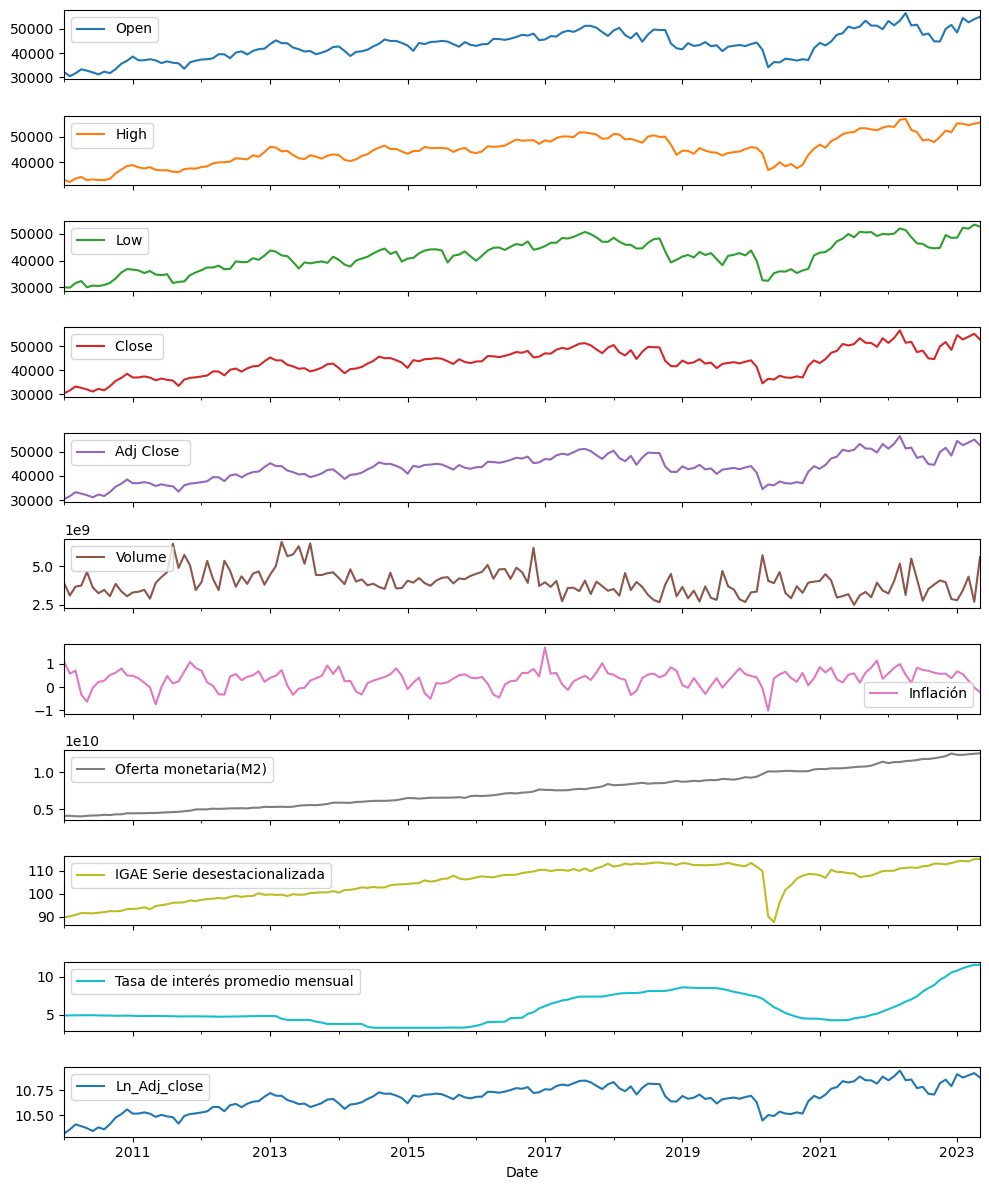

In [6]:
#Gáficos de comportamiento de las variables:
data.plot(subplots=True, figsize=(10, 12))
plt.tight_layout()
plt.show()


#### Distribución de los datos

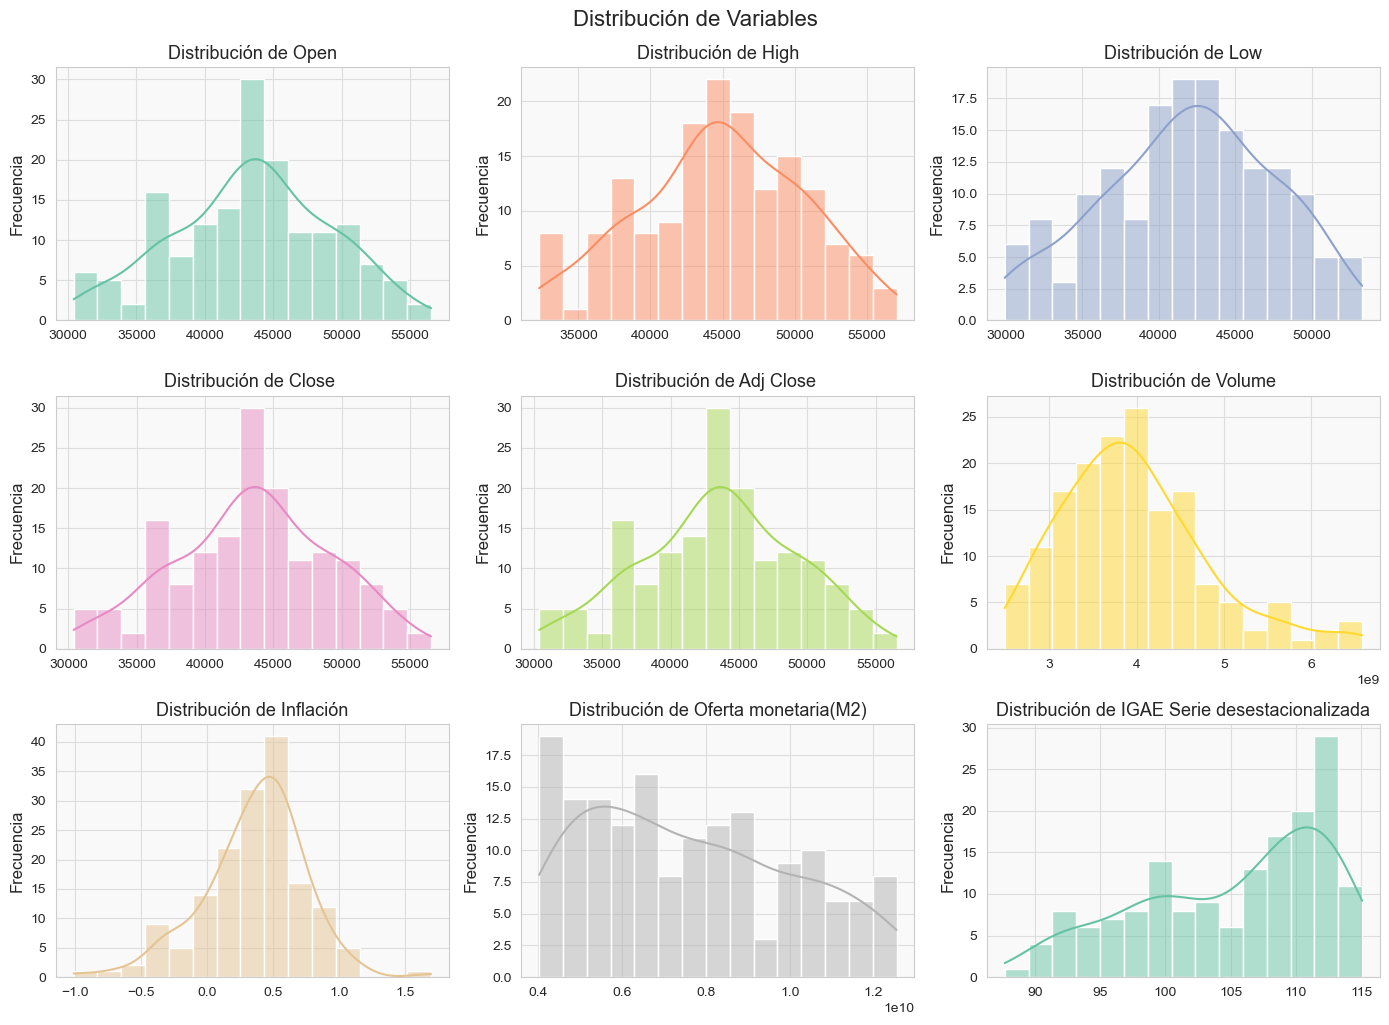

In [7]:

sns.set_style("whitegrid")
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.facecolor': 'white',
    'axes.facecolor': '#f9f9f9',
    'axes.edgecolor': '#cccccc',
    'grid.color': '#dddddd'
})

# Creamos histogramas 
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 10))  # Ajusta según número de variables
axes = axes.flatten()

for i, col in enumerate(data.columns[:len(axes)]):  # Evita error si hay menos columnas
    sns.histplot(data[col], bins=15, kde=True, ax=axes[i],
                 color=sns.color_palette("Set2")[i % 8])
    axes[i].set_title(f'Distribución de {col}', fontsize=13)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frecuencia')

# Eliminamos los ejes vacíos si hay menos de 9 columnas
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Distribución de Variables', fontsize=16, y=1.02)
plt.show()

Matriz de correlación

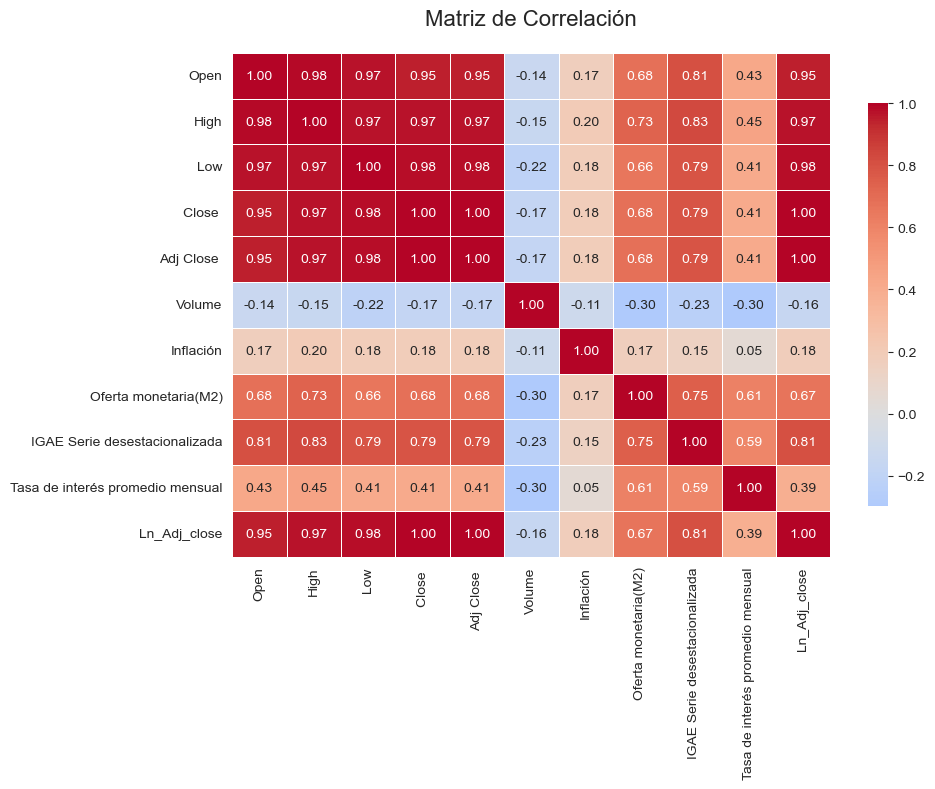

In [8]:
# Contrucción de la matriz de correlación
correlation_matrix = data.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,              
    fmt=".2f",                
    cmap='coolwarm',          
    center=0,                
    linewidths=0.5,           
    cbar_kws={'shrink': 0.8}  
)

plt.title('Matriz de Correlación', fontsize=16, pad=20)

plt.tight_layout()
plt.show()

#### Modelos econométricos:

Una vez explorados los datos, proceso a la construcción del modelo siguiendo a Gujarati y Porter (2010), si se corriera la regresión como se especifica para ver el comportamiento de las variables, a través del siguiente modelo:

$$ ln(IPC_t) = \beta_0 + \beta_1 \cdot \text{Actividad Económica}_t + \beta_2 \cdot \text{Tasa de Interés}_t + \beta_3 \cdot \text{Oferta Monetaria}_t + \beta_4 \cdot \text{Inflación}_t  + \varepsilon_t 
$$


se caería en un gran riesgo en hacer una regresión espuria. En ese sentido, se procede (siguiendo a los mismos autores) a revisar la estacionariedad de las variables correspondientes al modelo bajo la prueba ADF (Dickey Fuller Aumentada), a saber que si se obtiene que todas las variables son estacionarias en niveles, se puede proceder a hacer este análisis estático bajo la técnica de regresión lineal multiple.

En el caso de que no se obtenga dicho resultado, y de acuerdo con estos autores, se pocederá a construir un modelo ARIMA para la predicción de la variable ln (IPC), y luego esta misma predicción será contrastada con un Modelo Autorregresivo de Rezagos Distribuidos que tome en cuenta las variables macroeconómicas.

#### Planteamiento teórico basado en Gujarati y Porter (2010) y Wooldridge (2013) para la prueba ADF:

##### a) Estacionariedad y sus efectos dentro un modelo econométrico

Siguiendo el planteamiento de Gujarati y Porter (2010), seguimos los siguientes criterios para la estacionariedad de una serie de tiempo, en términos de estacionariedad:

Sea:
$$
y_t = \alpha + \rho \, y_{t-1} + \varepsilon_t
$$


donde:
- \( $\alpha$ \) = constante (deriva)
- \( $\rho $\) = coeficiente autorregresivo
- \( $\varepsilon_t$ \) = término de error (ruido blanco)

1. **Serie estacionaria**  
   $$
   \rho < 1
   $$

2. **Caminata aleatoria pura**  
   $$
   \rho = 1 \quad \land \quad \alpha = 0
   $$

3. **Caminara aleatoria con deriva**  
   $$
   \rho = 1 \quad \land \quad \alpha \neq 0
   $$

Este planteamiento es la base para el análisis de series de tiempo dentro del documento, ya que buscamos estacionariedad en términos de las variables macroeconómicas, así como el logaritmo natural del IPC. **Al trabajar con variables estacionarias se evita el problema de hacer una regresión espurea.**

##### b) Prueba Dickey Fuller Aumentada de Raíz Unitaria.

La Prueba de Dickey-Fuller Aumentada (ADF) es un contraste estadístico diseñado para detectar la presencia de **raíces unitarias** en series de tiempo, esto es equivalente a verificar si una serie es **no estacionaria**.

Siguiendo a Gujarati y Porter (2010) y Wooldridge (2013), se puede afirmar que la presencia de una raíz unitaria implica que los choques en la serie tienen efectos permanentes, y por tanto, la media y la varianza no son constantes en el tiempo.

Como modelo básico para estos efectos tenemos:

Partimos de un proceso autorregresivo de primer orden:

$$
y_t = \rho y_{t-1} + u_t
$$

donde:
- \( $y_t$ \) es la variable de interés.
- \( $\rho$ \) es el coeficiente autorregresivo.
- \( $u_t $\) es un término de error con \( $E(u_t)$ = 0 \), \( $\text{Var}(u_t) = \sigma^2 $\) y sin autocorrelación.

**Para la trasformación de la prueba, desarrollamos:**

Restando \( $y_{t-1} $\) en ambos lados:

$$
y_t - y_{t-1} = \rho y_{t-1} - y_{t-1} + u_t
$$

$$
\Delta y_t = (\rho - 1) y_{t-1} + u_t
$$

Definimos:

$$
\delta = \rho - 1
$$

y obtenemos:

$$
\Delta y_t = \delta y_{t-1} + u_t
$$

**Con las siguientes hipótesis corresponfientes a la prueba:**

- **Hipótesis nula (H₀)**: \( $\delta = 0$ \)  ⟺  \( $\rho = 1$ \) → Existe raíz unitaria → Serie no estacionaria.

- **Hipótesis alternativa (H₁)**: \( $\delta < 0$ \)  ⟺  \( $|\rho| < 1$ \) → Serie estacionaria.

*En relación a la prueba Dickey-Fuller Aumentada:*

Al trabajar con una serie de tiempo, el error estócastico puede estar autocorrelacionado, para poder corregir este efecto, se añaden rezagos de la variable dependiente en diferencias, Gujarati y Porter (2010) y Wooldridge (2013):

- Sin constante ni tendencia:
$$
\Delta y_t = \gamma y_{t-1} + \sum_{i=1}^p \alpha_i \Delta y_{t-i} + \varepsilon_t
$$

- Con constante:
$$
\Delta y_t = \alpha + \gamma y_{t-1} + \sum_{i=1}^p \alpha_i \Delta y_{t-i} + \varepsilon_t
$$

-  Con constante y tendencia:
$$
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^p \alpha_i \Delta y_{t-i} + \varepsilon_t
$$

donde:
- \( $p $\) es el número de rezagos incluidos para eliminar autocorrelación.
- \( $\beta_t $\) representa una tendencia determinista.

Según Gujarati y Porter (2010) y *Wooldridge (2013), el número de rezagos \( $p $\) se elige para que los residuos \( $\varepsilon_t $\) sean ruido blanco.

$$
\varepsilon_t \overset{i.i.d.}{\sim} \mathcal{N}(0, \sigma^2)
$$

**Estadísticos de prueba de DFA:**

La prueba se basa en el estadístico t de \( $\gamma$ \) (o \( $\delta $\)), pero sus valores críticos no siguen la distribución t de Student estándar, por tal motivo, se deben usar las tablas específicas para esta prueba.

**Regla de desición ADF tau:**

$$
\text{Si } \tau_{\text{ADF}} < \tau_{\alpha} \quad \Rightarrow \quad \text{Rechazar } H_0 \ (\text{serie estacionaria})
$$
$$
\text{Si } \tau_{\text{ADF}} \geq \tau_{\alpha} \quad \Rightarrow \quad \text{No rechazar } H_0 \ (\text{serie no estacionaria})
$$

**Regla de decisión usando el valor p:**

$$
\text{Si } p\text{-valor} \leq \alpha \quad \Rightarrow \quad \text{Rechazar } H_0
$$
$$
\text{Si } p\text{-valor} > \alpha \quad \Rightarrow \quad \text{No rechazar } H_0
$$


En el siguiente código, trabajo con ambos criterios bajo una significancia del 5%

In [9]:
# Código para la prueba de Dickey-Fuller aumentada (ADF), con valor p (criterio estándar):


def adf_test(series, signif=0.05):
    """
    Aplicamos la prueba ADF a una serie y devuelve True si es estacionaria.
    """
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    return p_value <= signif, p_value

# Listas para clasificar
estacionarias = []
no_estacionarias = []

# Recorremos solo columnas numéricas
for col in data.select_dtypes(include='number').columns:
    es_estacionaria, p_val = adf_test(data[col])
    if es_estacionaria:
        estacionarias.append((col, p_val))
    else:
        no_estacionarias.append((col, p_val))

# Mostrar resultados
print(" RESULTADOS PRUEBA ADF")
print("\n Variables estacionarias:")
for col, p in estacionarias:
    print(f"  - {col} (p-valor = {p:.4f})")

print("\n Variables NO estacionarias:")
for col, p in no_estacionarias:
    print(f"  - {col} (p-valor = {p:.4f})")
    

 RESULTADOS PRUEBA ADF

 Variables estacionarias:
  - Volume (p-valor = 0.0044)

 Variables NO estacionarias:
  - Open (p-valor = 0.2599)
  - High (p-valor = 0.3031)
  - Low (p-valor = 0.2543)
  - Close  (p-valor = 0.1288)
  - Adj Close  (p-valor = 0.1288)
  - Inflación (p-valor = 0.2969)
  - Oferta monetaria(M2) (p-valor = 1.0000)
  - IGAE Serie desestacionalizada (p-valor = 0.2536)
  - Tasa de interés promedio mensual (p-valor = 0.2283)
  - Ln_Adj_close (p-valor = 0.0874)


In [10]:
# Código para la prueba de Dickey-Fuller aumentada (ADF) usando el valor crítico tau

def adf_test_tau(series, signif=0.05):
    """
    Aplicamos la prueba ADF y decide usando el valor crítico tau.
    Se retorna True si la serie es estacionaria según tau.
    """
    
    result = adfuller(series, autolag='AIC')
    
    tau_stat = result[0]           # estadístico τ de ADF
    crit_values = result[4]        # diccionario de valores críticos
    # Seleccionamos el valor crítico según el nivel de significancia
    tau_crit = crit_values[f"{int(signif*100)}%"]
    
    return tau_stat < tau_crit, tau_stat, tau_crit

# Listas para clasificar
estacionarias = []
no_estacionarias = []

# Recorremos solo columnas numéricas
for col in data.select_dtypes(include='number').columns:
    es_estacionaria, tau_stat, tau_crit = adf_test_tau(data[col])
    if es_estacionaria:
        estacionarias.append((col, tau_stat, tau_crit))
    else:
        no_estacionarias.append((col, tau_stat, tau_crit))

# Mostrar resultados
print(" RESULTADOS PRUEBA ADF (criterio τ)")
print("\n Variables estacionarias:")
for col, tau_s, tau_c in estacionarias:
    print(f"  - {col}: τ = {tau_s:.4f}, τ_crit = {tau_c:.4f}")

print("\n Variables no estacionarias:")
for col, tau_s, tau_c in no_estacionarias:
    print(f"  - {col}: τ = {tau_s:.4f}, τ_crit = {tau_c:.4f}")

 RESULTADOS PRUEBA ADF (criterio τ)

 Variables estacionarias:
  - Volume: τ = -3.6827, τ_crit = -2.8800

 Variables no estacionarias:
  - Open: τ = -2.0624, τ_crit = -2.8798
  - High: τ = -1.9628, τ_crit = -2.8799
  - Low: τ = -2.0758, τ_crit = -2.8798
  - Close : τ = -2.4475, τ_crit = -2.8798
  - Adj Close : τ = -2.4475, τ_crit = -2.8798
  - Inflación: τ = -1.9767, τ_crit = -2.8811
  - Oferta monetaria(M2): τ = 3.1183, τ_crit = -2.8815
  - IGAE Serie desestacionalizada: τ = -2.0776, τ_crit = -2.8800
  - Tasa de interés promedio mensual: τ = -2.1412, τ_crit = -2.8801
  - Ln_Adj_close: τ = -2.6278, τ_crit = -2.8798


Voy a acotar el análisis, solamente usaré un dataframe en donde solo existan las variables de interés, ya que se ofreció una visión que engloba la estacionariedad de todas las variables limpias. 

En esta parte, también procedo a obtener la estacionariedad de las variables que interesan al documento.

In [11]:
#Construcción del dataframe acotado a las variables de interés:

data_acotado = data[['Ln_Adj_close', 'Tasa de interés promedio mensual', 'IGAE Serie desestacionalizada', 'Oferta monetaria(M2)', 'Inflación']]
data_acotado

,Ln_Adj_close,Tasa de interés promedio mensual,IGAE Serie desestacionalizada,Oferta monetaria(M2),Inflación
Date,,,,,
2010-01-01,10.321922,4.91,89.7876,4.081855e+09,1.09
2010-02-01,10.362005,4.92,90.1886,4.094608e+09,0.58
2010-03-01,10.412304,4.92,90.8336,4.032745e+09,0.71
2010-04-01,10.394743,4.94,91.6445,4.019685e+09,-0.32
2010-05-01,10.374695,4.94,91.5642,4.093547e+09,-0.63
...,...,...,...,...,...
2023-01-01,10.907135,10.78,114.0758,1.235475e+10,0.68
2023-02-01,10.873472,11.10,114.2686,1.234473e+10,0.56
2023-03-01,10.894960,11.34,114.0644,1.242759e+10,0.27


**Uso de la media móvil en relación a la tasa de interés**

In [12]:
#Obtenemos la media móvil de 12 meses para la tasa de interés, ya que es una variable muy volátil y con mucha variabilidad.

print("--- Aplicando Media Móvil de 12 meses a la Tasa de Interés ---")
data_acotado['Tasa de interés promedio mensual'] = data_acotado['Tasa de interés promedio mensual'].rolling(window=12).mean()
data_acotado.dropna(inplace=True)
print("DataFrame con tasa de interés suavizada (primeras filas):")
print(data_acotado.head())

# Diferenciamos las series no estacionarias hasta que todas sean estacionarias
print("\n--- Diferenciando series hasta alcanzar estacionariedad ---")
df_estacionario = data_acotado.copy()

alpha = 0.05
orden_integracion = {}

for column in df_estacionario.columns:
    d = 0
    # Revisa si la columna necesita ser diferenciada antes de entrar al bucle.
    p_value = adfuller(df_estacionario[column].dropna())[1]
    
    while p_value > alpha:
        d += 1
        df_estacionario[column] = df_estacionario[column].diff()
        # Se eliminan los NaNs de la columna específica para la prueba ADF
        p_value = adfuller(df_estacionario[column].dropna())[1]

    orden_integracion[column] = d

# Limpieza final de todos los NaNs generados en el proceso.
df_estacionario.dropna(inplace=True)

print("\nOrden de integración (veces que se diferenció cada serie):")
print(orden_integracion)

print("\n--- DataFrame Final con Series Estacionarias (primeras filas) ---")
print(df_estacionario.head())

# Guardamos los resultados finales para tu análisis.
df_estacionario.to_csv('dataframe_final_estacionario.csv')
print("\nArchivo 'dataframe_final_estacionario.csv' guardado con éxito.")


--- Aplicando Media Móvil de 12 meses a la Tasa de Interés ---
DataFrame con tasa de interés suavizada (primeras filas):
            Ln_Adj_close  Tasa de interés promedio mensual  \
Date                                                         
2010-12-01     10.559732                          4.910000   
2011-01-01     10.518193                          4.905833   
2011-02-01     10.519205                          4.899167   
2011-03-01     10.530509                          4.892500   
2011-04-01     10.517662                          4.885000   

            IGAE Serie desestacionalizada  Oferta monetaria(M2)  Inflación  
Date                                                                        
2010-12-01                        93.3320          4.442010e+09       0.50  
2011-01-01                        93.4032          4.431859e+09       0.49  
2011-02-01                        93.6078          4.441379e+09       0.38  
2011-03-01                        94.1319          4.444645

C:\Users\gabri\AppData\Local\Temp\ipykernel_7288\490604858.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_acotado['Tasa de interés promedio mensual'] = data_acotado['Tasa de interés promedio mensual'].rolling(window=12).mean()
C:\Users\gabri\AppData\Local\Temp\ipykernel_7288\490604858.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_acotado.dropna(inplace=True)


In [13]:
df_estacionario

,Ln_Adj_close,Tasa de interés promedio mensual,IGAE Serie desestacionalizada,Oferta monetaria(M2),Inflación
Date,,,,,
2011-02-01,0.001012,-0.006667,0.2046,1.967042e+07,-0.11
2011-03-01,0.011303,-0.006667,0.5241,-6.254412e+06,-0.19
2011-04-01,-0.012846,-0.007500,-0.8280,2.890961e+07,-0.20
2011-05-01,-0.031044,-0.007500,1.3426,-3.875926e+07,-0.73
2011-06-01,0.020039,-0.007500,0.4217,6.361091e+07,0.74
...,...,...,...,...,...
2023-01-01,0.118561,0.421667,0.7484,-5.051616e+08,0.30
2023-02-01,-0.033663,0.423333,0.1928,1.508340e+08,-0.12
2023-03-01,0.021488,0.417500,-0.2042,9.288270e+07,-0.29


### Análisis usando modelo ARIMA

1) Primer modelo




In [14]:
warnings.filterwarnings("ignore")

#Construcción del modelo arima para cada IPC no estacionaria:

serie_ipc_estacionaria = df_estacionario['Ln_Adj_close']
# auto_arima buscará los mejores órdenes p y q para la serie ya estacionaria
# Se establece d=0 porque la serie ya fue diferenciada
modelo_arima = auto_arima(serie_ipc_estacionaria, 
                          start_p=1, 
                          start_q=1, 
                          test='adf', 
                          max_p=3, 
                          max_q=3, 
                          m=1, 
                          d=0,  # Importante: d=0 porque la serie ya es estacionaria
                          seasonal=False, 
                          trace=True, 
                          error_action='ignore', 
                          suppress_warnings=True, 
                          stepwise=True)

print("\n--- Resumen del Mejor Modelo ARIMA sobre Datos Estacionarios ---")
print(modelo_arima.summary())




Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-514.218, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-515.935, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-516.079, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-516.189, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-514.231, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-512.928, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-514.853, Time=0.19 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.934 seconds

--- Resumen del Mejor Modelo ARIMA sobre Datos Estacionarios ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  148
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 260.094
Date:                Sun, 05 Oct 2025   AIC                           -516.189
Time:                        14:38:3

2) Segundo modelo ARIMA

In [15]:
#Construímos el modelo ARIMA para la serie original no estacionaria del logaritmo del IPC: 
serie_ipc_no_estacionaria = data_acotado['Ln_Adj_close']

modelo_arima_ii = auto_arima(serie_ipc_no_estacionaria,
                                  start_p=1, start_q=1,
                                  test='adf',       # Dejamos que la función encuentre 'd'
                                  max_p=3, max_q=3,
                                  seasonal=False,
                                  trace=True,
                                  error_action='ignore',  
                                  suppress_warnings=True, 
                                  stepwise=True)

print("\n--- Resumen del Mejor Modelo ARIMA (desde un enfoque estándar) ---")
print(modelo_arima_ii.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-516.320, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-517.832, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-518.115, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-518.261, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-519.459, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.541 seconds

--- Resumen del Mejor Modelo ARIMA (desde un enfoque estándar) ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  150
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 260.730
Date:                Sun, 05 Oct 2025   AIC                           -519.459
Time:                        14:38:34   BIC                           -516.455
Sample:                    12-01-2010   HQIC                          -518.239
        

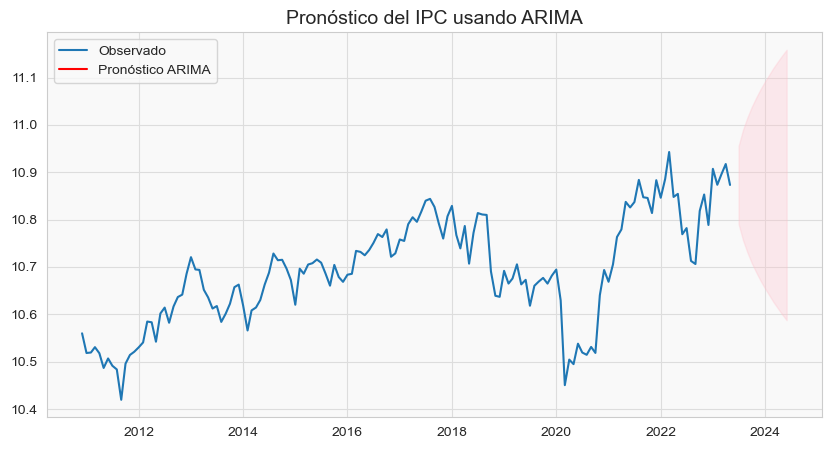

In [16]:
#contruímos el pronóstico a 12 meses con el modelo ARIMA estándar:
n_periods = 12
fc, confint = modelo_arima_ii.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(serie_ipc_no_estacionaria.index[-1], periods=n_periods + 1, freq='M')[1:]
# Creamos un DataFrame para los pronósticos
fc_series = pd.Series(fc, index=index_of_fc)
# Graficamos los resultados
plt.figure(figsize=(10, 5))
plt.plot(serie_ipc_no_estacionaria, label='Observado')
plt.plot(fc_series, label='Pronóstico ARIMA', color='red')
plt.fill_between(index_of_fc, confint[:, 0], confint[:, 1], color='pink', alpha=0.3)
plt.title('Pronóstico del IPC usando ARIMA')
plt.legend()
plt.show()

#### El Modelo Autorregresivo de Rezagos Distribuidos

Aplico este modelo para hallar la variable macroeconómica más fuerte en términos explicativos, lo que se busca al usar este algoritmo, es que la selección sea consistente con el análisis que se ofrece posteriormente (en el ordenamiento de relevancia de variables macro) en la parte de Machine Learning.

La aplicación de este modelo econométrico se hace para potenciar el poder explicativo y constatar la hipótesis planteada.

1) **Primer modelo orientado al corto plazo**

In [ ]:
warnings.filterwarnings("ignore")

#Construimos el modelo autorregresivo de rezagos distribuidos (ARDL) (con datos estacinonarios, que nos da un análisis a corto plazo):

# Definimos la variable dependiente (endog) y las independientes (exog)
y = df_estacionario['Ln_Adj_close']
X = df_estacionario[['Inflación', 'Oferta monetaria(M2)', 'IGAE Serie desestacionalizada', 'Tasa de interés promedio mensual']]

# Buscamos el orden de rezagos óptimo (hasta un máximo de 5 para cada variable)
seleccion = ardl_select_order(y, 5, X, 5, ic='aic', trend='c')
print(f"Orden de rezagos óptimo seleccionado: {seleccion.ar_lags} para Ln_Adj_close y {seleccion.dl_lags} para las exógenas.")

# Construimos el modelo ARDL con los rezagos óptimos encontrados
modelo_ardl = ARDL(y, seleccion.ar_lags, X, seleccion.dl_lags, trend='c')
resultado_ardl = modelo_ardl.fit()

print("\n--- Resumen del Modelo ARDL ---")
print(resultado_ardl.summary())

# Realizamos la prueba de límites para cointegración
print("\n--- Prueba de Límites para Cointegración (Bounds Test) ---")
print(resultado_ardl.summary())

Orden de rezagos óptimo seleccionado: [1] para Ln_Adj_close y {'Oferta monetaria(M2)': [0]} para las exógenas.

--- Resumen del Modelo ARDL ---
                              ARDL Model Results                              
Dep. Variable:           Ln_Adj_close   No. Observations:                  148
Model:                     ARDL(1, 0)   Log Likelihood                 260.938
Method:               Conditional MLE   S.D. of innovations              0.041
Date:                Sun, 05 Oct 2025   AIC                           -513.875
Time:                        14:38:39   BIC                           -501.913
Sample:                    03-01-2011   HQIC                          -509.015
                         - 05-01-2023                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0028      

Gráfico de modelo autorregresivo de rezafos distribuídos

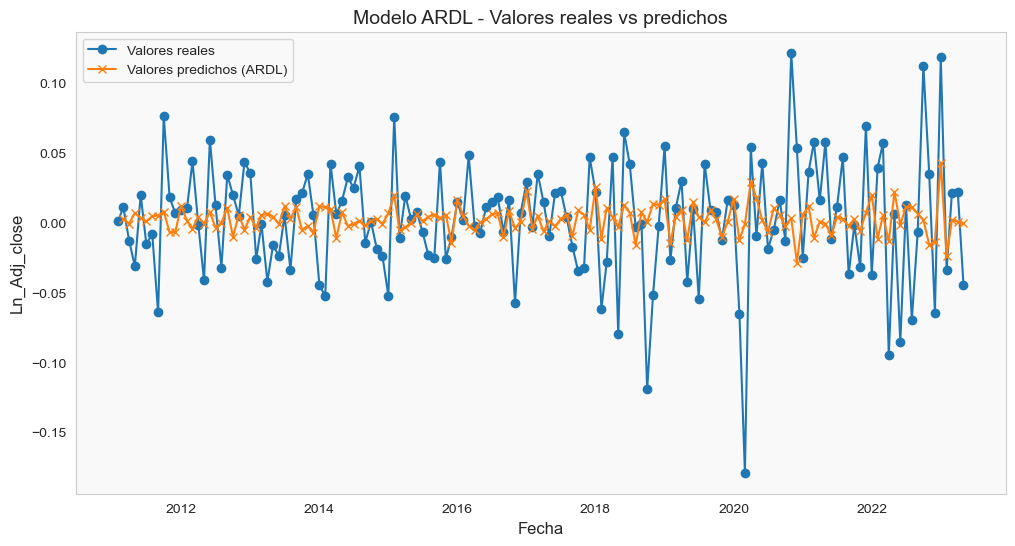

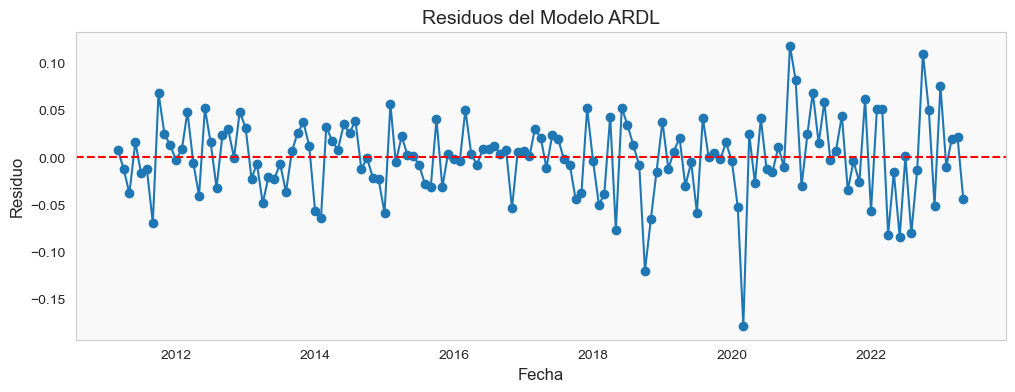

In [18]:
#Construcción de gráficos para visualizar los resultados del modelo ARDL


# Predicciones alineadas con el índice original
y_pred = resultado_ardl.fittedvalues
y_pred.index = y.index[-len(y_pred):]  # Alinear índices

# 1️. Predicciones vs valores reales
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label='Valores reales', marker='o')
plt.plot(y_pred.index, y_pred, label='Valores predichos (ARDL)', marker='x')
plt.xlabel('Fecha')
plt.ylabel('Ln_Adj_close')
plt.title('Modelo ARDL - Valores reales vs predichos')
plt.legend()
plt.grid()
plt.show()

# 2️. Residuos
residuos = resultado_ardl.resid
residuos.index = y.index[-len(residuos):]  # Alinear índices

plt.figure(figsize=(12,4))
plt.plot(residuos.index, residuos, marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Residuo')
plt.title('Residuos del Modelo ARDL')
plt.grid()
plt.show()


2) **Análisis en niveles, orientado para estudiar el largo plazo y hallar cointegración en las variables**

Orden de rezagos óptimo seleccionado (niveles): [1] para Ln_Adj_close y {'Oferta monetaria(M2)': [0, 1], 'IGAE Serie desestacionalizada': [0], 'Tasa de interés promedio mensual': [0, 1]} para las exógenas.

--- Resumen del Modelo ARDL en Niveles ---
                              ARDL Model Results                              
Dep. Variable:           Ln_Adj_close   No. Observations:                  150
Model:               ARDL(1, 1, 0, 1)   Log Likelihood                 273.971
Method:               Conditional MLE   S.D. of innovations              0.038
Date:                Sun, 05 Oct 2025   AIC                           -531.943
Time:                        14:38:45   BIC                           -507.911
Sample:                    01-01-2011   HQIC                          -522.179
                         - 05-01-2023                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------

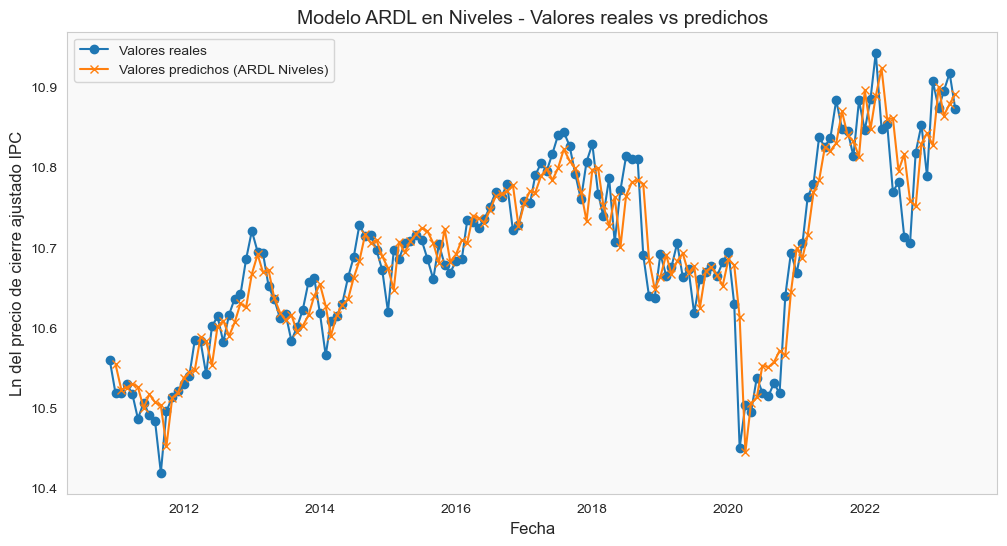

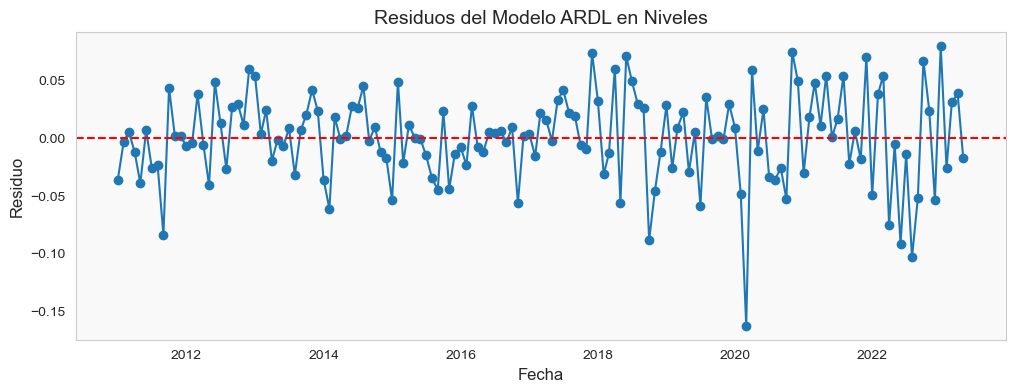

In [ ]:

#Ahora construímos el modelo con datos no estacionarios (en niveles), que nos da un análisis a largo plazo:
# Definición de la variable dependiente (endog) y las independientes (exog) en niveles
y_niveles = data_acotado['Ln_Adj_close']
X_niveles = data_acotado[['Inflación', 'Oferta monetaria(M2)', 'IGAE Serie desestacionalizada', 'Tasa de interés promedio mensual']]

# Buscamos el orden de rezagos óptimo (hasta un máximo de 5 para cada variable)
seleccion_niveles = ardl_select_order(y_niveles, 5, X_niveles, 5, ic='aic', trend='c')
print(f"Orden de rezagos óptimo seleccionado (niveles): {seleccion_niveles.ar_lags} para Ln_Adj_close y {seleccion_niveles.dl_lags} para las exógenas.")

# Construcción el modelo ARDL con los rezagos óptimos encontrados
modelo_ardl_niveles = ARDL(y_niveles, seleccion_niveles.ar_lags, X_niveles, seleccion_niveles.dl_lags, trend='c')
resultado_ardl_niveles = modelo_ardl_niveles.fit()
print("\n--- Resumen del Modelo ARDL en Niveles ---")
print(resultado_ardl_niveles.summary())

# Realizamos la prueba de límites para cointegración en niveles
print("\n--- Prueba de Límites para Cointegración en Niveles (Bounds Test) ---")
print(resultado_ardl_niveles.summary())


#GRáficamente visualizamos los resultados del modelo ARDL en niveles
# Predicciones alineadas con el índice original
y_pred_niveles = resultado_ardl_niveles.fittedvalues
y_pred_niveles.index = y_niveles.index[-len(y_pred_niveles):]  # Alinear índices
# 1️. Predicciones vs valores reales en niveles
plt.figure(figsize=(12,6))
plt.plot(y_niveles.index, y_niveles, label='Valores reales', marker='o')
plt.plot(y_pred_niveles.index, y_pred_niveles, label='Valores predichos (ARDL Niveles)', marker='x')
plt.xlabel('Fecha')
plt.ylabel('Ln del precio de cierre ajustado IPC')
plt.title('Modelo ARDL en Niveles - Valores reales vs predichos')
plt.legend()
plt.grid()
plt.show()
# 2️. Residuos en niveles
residuos_niveles = resultado_ardl_niveles.resid
residuos_niveles.index = y_niveles.index[-len(residuos_niveles):]  # Alinear índices
plt.figure(figsize=(12,4))
plt.plot(residuos_niveles.index, residuos_niveles, marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Residuo')
plt.title('Residuos del Modelo ARDL en Niveles')
plt.grid()
plt.show()


##### ¿Qué tipo de relación cuardan la oferta monetaria $M_2$ con el logaritmo del IPC?

Este análisis se hace para sustentar la diferenciación de las variables de interés y no caer en una regresión espurea. 

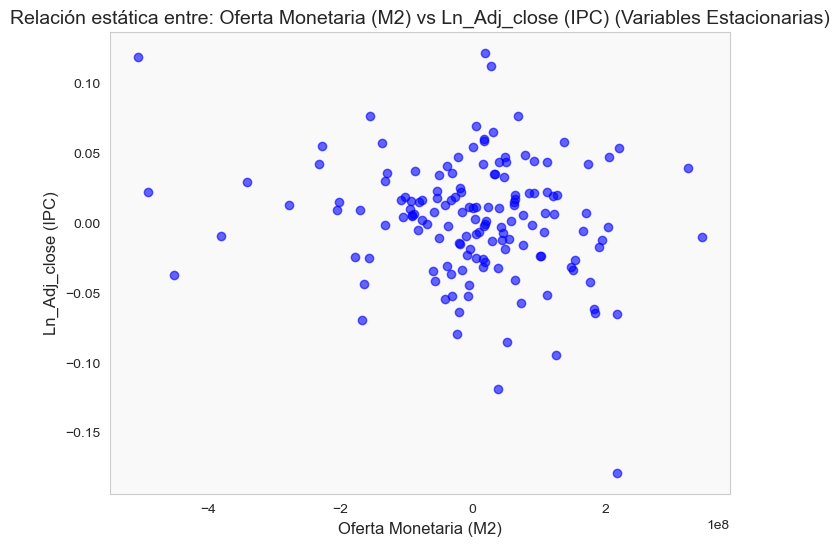

In [20]:
#Vamos a contruir un scatter plot entre la oferta monetaria y el IPC para ver si hay una relación visual entre ambas variables.
plt.figure(figsize=(8,6))
plt.scatter(df_estacionario['Oferta monetaria(M2)'], df_estacionario['Ln_Adj_close'], color='blue', alpha=0.6)
plt.title('Relación estática entre: Oferta Monetaria (M2) vs Ln_Adj_close (IPC) (Variables Estacionarias)')
plt.xlabel('Oferta Monetaria (M2)') 
plt.ylabel('Ln_Adj_close (IPC)')
plt.grid()
plt.show()

### Predicción del IPC usando técnicas de Machine Learning (Integración de la economía con la Ciencia de Datos)



En esta parte del análisis, ofrezco una visión integrativa, ya que voy a trabajar con esta serie tamporal con los algoritmos citados. Además de que se añade al análisis, en aras de conducir el documento por una buena práctica, el desarrollo de un modelo Lasso, ya que se busca de aplicarlo como selector de variables. 

Siguiendo la literatura correspondiente, como en Géron, A. (2022) y Brownlee, J. (2018), este problema de trabajo con series temporales se convierte en un análisis de aprendizaje supervizado, esto para la correcta construcción de los modelos ofrecidos para la predicción del comportamiento del IPC.


#### 1. XGBoost (eXtreme Gradient Boosting)






--- Evaluación del Modelo XGBoost ---
R² Entrenamiento: 0.8505
R² Prueba: -0.3270
MSE (Prueba): 0.0037
RMSE (Prueba): 0.0607
MAE (Prueba): 0.0502


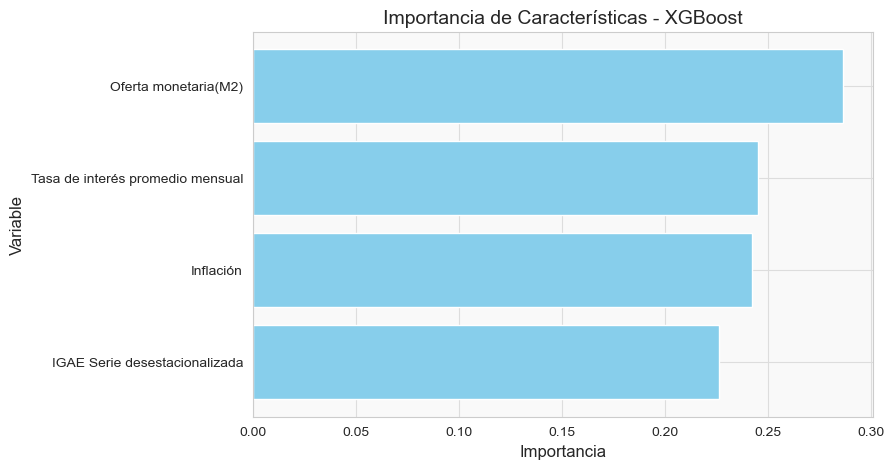

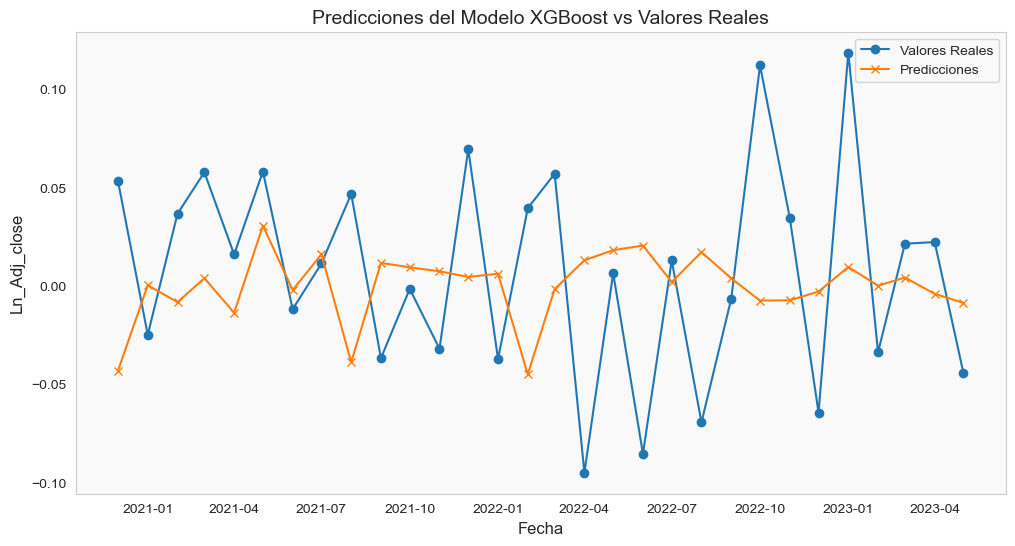

In [21]:
#Vamos construyedo el modelo XGBoost para predecir el Ln_Adj_close a partir de las variables macroeconómicas.
# Variables dependiente e independientes
y = df_estacionario['Ln_Adj_close']
X = df_estacionario[['Inflación', 'Oferta monetaria(M2)', 'IGAE Serie desestacionalizada', 'Tasa de interés promedio mensual']]

# División entrenamiento / prueba
split_index = int(len(df_estacionario) * 0.8) # 80% entrenamiento, 20% prueba
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Modelo XGBoost
model_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=12345,
    n_jobs=-1
)

# Entrenamiento
model_xgb.fit(X_train, y_train)

# Predicciones
y_pred_train = model_xgb.predict(X_train)
y_pred_test = model_xgb.predict(X_test)

# Métricas
mse_test = np.mean((y_test - y_pred_test) ** 2)
rmse_test = np.sqrt(mse_test)
mae_test = np.mean(np.abs(y_test - y_pred_test))

r2_train = model_xgb.score(X_train, y_train)
r2_test = model_xgb.score(X_test, y_test)

print("\n--- Evaluación del Modelo XGBoost ---")
print(f"R² Entrenamiento: {r2_train:.4f}")
print(f"R² Prueba: {r2_test:.4f}")
print(f"MSE (Prueba): {mse_test:.4f}")
print(f"RMSE (Prueba): {rmse_test:.4f}")
print(f"MAE (Prueba): {mae_test:.4f}")

# Importancia de características
# Obtener importancia y ordenarla
importancias = model_xgb.feature_importances_
features = X.columns
df_importancia = pd.DataFrame({'Variable': features, 'Importancia': importancias})
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False)

# Graficar
plt.figure(figsize=(8,5))
plt.barh(df_importancia['Variable'], df_importancia['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de Características - XGBoost')
plt.gca().invert_yaxis()  # Para que la más importante aparezca arriba
plt.show()


# Comparación visual de predicciones vs reales
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Valores Reales', marker='o')
plt.plot(y_test.index, y_pred_test, label='Predicciones', marker='x')
plt.xlabel('Fecha')
plt.ylabel('Ln_Adj_close')
plt.title('Predicciones del Modelo XGBoost vs Valores Reales')
plt.legend()
plt.grid()
plt.show()

#### XGBoost II, sin sobreajuste

--- Iniciando búsqueda de hiperparámetros para XGBoost con GridSearchCV ---
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Mejores parámetros encontrados: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

--- Evaluación del Modelo XGBoost OPTIMIZADO ---
Puntaje R² en entrenamiento: 0.9436
Puntaje R² en prueba: -0.1454
RMSE en prueba: 0.0566
MAE en prueba: 0.0456


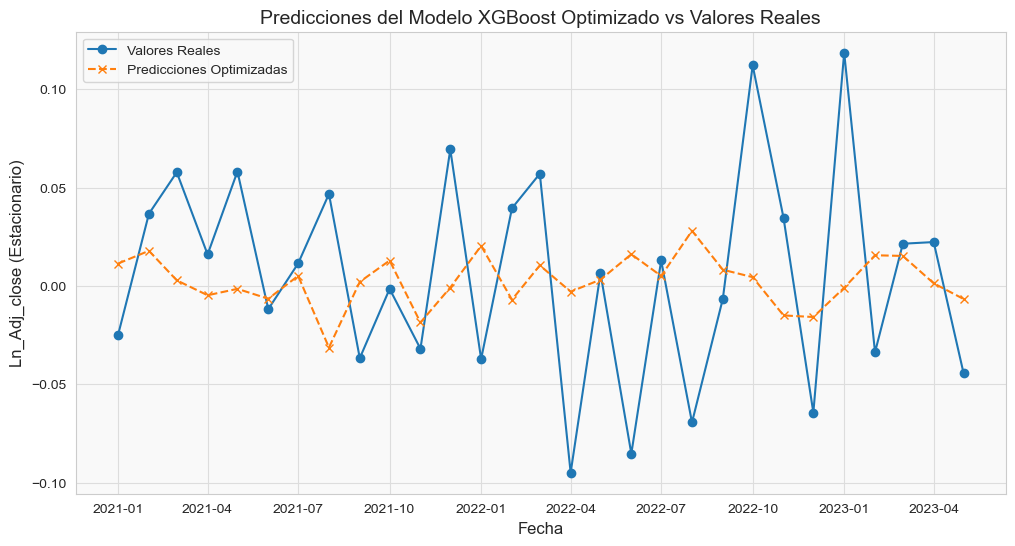

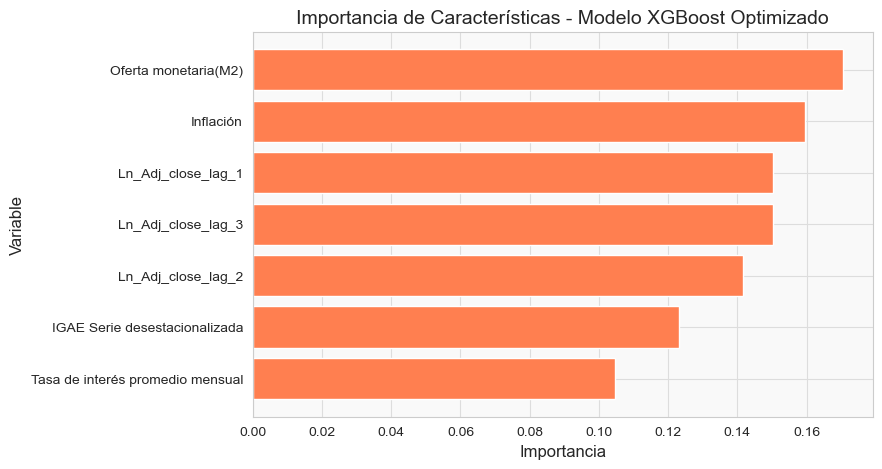

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- 1. Ingeniería de Características: Creación de Rezagos ---
# Hacemos una copia para no modificar el df original
df_xgb = df_estacionario.copy()

# Añadimos lags de la variable objetivo (Ln_Adj_close) como nuevas características predictoras
n_lags = 3
for i in range(1, n_lags + 1):
    df_xgb[f'Ln_Adj_close_lag_{i}'] = df_xgb['Ln_Adj_close'].shift(i)

# Eliminamos los NaNs creados por los rezagos
df_xgb.dropna(inplace=True)

# --- 2. Definición de Variables y División de Datos ---
# 'X' ahora incluye las variables macro y los rezagos del IPC
X_xgb = df_xgb.drop(columns=['Ln_Adj_close'])
y_xgb = df_xgb['Ln_Adj_close']

# Dividimos en entrenamiento y prueba (80% - 20%) para la evaluación FINAL
split_index = int(len(df_xgb) * 0.8)
X_train, X_test = X_xgb.iloc[:split_index], X_xgb.iloc[split_index:]
y_train, y_test = y_xgb.iloc[:split_index], y_xgb.iloc[split_index:]

# --- 3. Búsqueda de Hiperparámetros con Validación Cruzada ---
print("--- Iniciando búsqueda de hiperparámetros para XGBoost con GridSearchCV ---")

# Definimos una grilla de parámetros más pequeña para una búsqueda eficiente
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Creamos el objeto de validación cruzada para series de tiempo
tscv = TimeSeriesSplit(n_splits=5)

# Creamos el modelo base
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=12345, n_jobs=-1)

# Creamos el objeto GridSearchCV
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, 
                           cv=tscv, n_jobs=-1, verbose=1, 
                           scoring='neg_root_mean_squared_error')

# Ejecutamos la búsqueda en el CONJUNTO DE ENTRENAMIENTO
grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo y sus parámetros
print(f"\nMejores parámetros encontrados: {grid_search.best_params_}")
best_xgb_model = grid_search.best_estimator_

# --- 4. Evaluación del Modelo Optimizado ---
# Hacemos predicciones en el conjunto de prueba con el modelo mejorado
y_pred = best_xgb_model.predict(X_test)

# Métricas de evaluación
train_score = best_xgb_model.score(X_train, y_train)
test_score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n--- Evaluación del Modelo XGBoost OPTIMIZADO ---")
print(f"Puntaje R² en entrenamiento: {train_score:.4f}")
print(f"Puntaje R² en prueba: {test_score:.4f}")
print(f"RMSE en prueba: {rmse:.4f}")
print(f"MAE en prueba: {mae:.4f}")

# --- 5. Visualización de Resultados ---
# Gráfico de predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Valores Reales', marker='o', linestyle='-')
plt.plot(y_test.index, y_pred, label='Predicciones Optimizadas', marker='x', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Ln_Adj_close (Estacionario)')
plt.title('Predicciones del Modelo XGBoost Optimizado vs Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de importancia de características del modelo optimizado
df_importancia = pd.DataFrame({
    'Variable': X_xgb.columns,
    'Importancia': best_xgb_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(df_importancia['Variable'], df_importancia['Importancia'], color='coral')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de Características - Modelo XGBoost Optimizado')
plt.gca().invert_yaxis()
plt.show()

#### 2. Random Forest 1



--- Evaluación 1 del Modelo Random Forest ---
Puntaje R² en entrenamiento: 0.6294
Puntaje R² en prueba: -0.2757
Importancia de las características: [0.25636429 0.31290641 0.22182905 0.20890024]
Características: ['Inflación', 'Oferta monetaria(M2)', 'IGAE Serie desestacionalizada', 'Tasa de interés promedio mensual']
Importancia de las características (con nombres): {'Inflación': np.float64(0.25636429472550964), 'Oferta monetaria(M2)': np.float64(0.3129064101306756), 'IGAE Serie desestacionalizada': np.float64(0.22182905241336837), 'Tasa de interés promedio mensual': np.float64(0.20890024273044644)}

--- Evaluación 2 del Modelo Random Forest ---
MSE: 0.0035
RMSE: 0.0595
MAE: 0.0479
R²: -0.2757


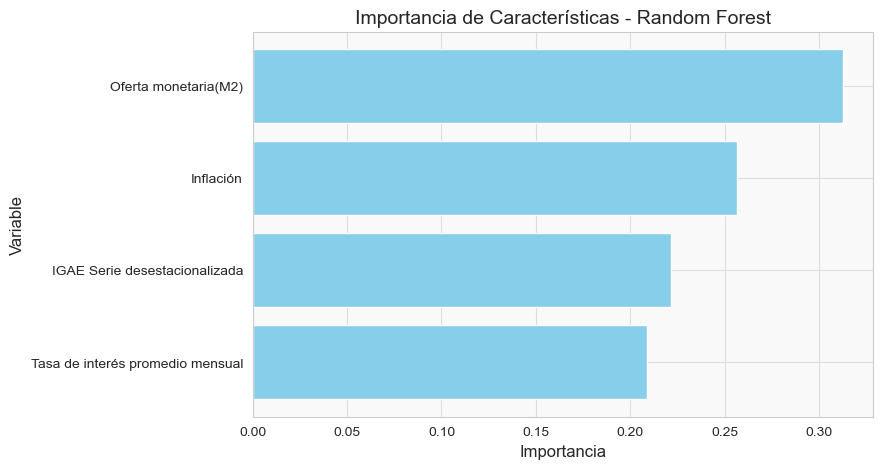

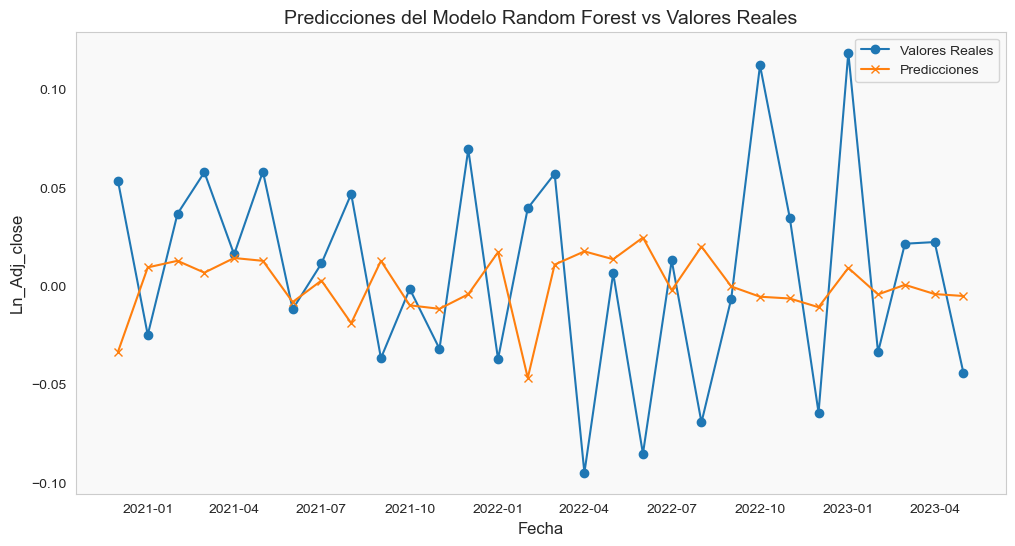

In [24]:
# Construcción del modelo Random Forest (Bosque Aleatorio) para predecir el IPC

# Definimos las variables independientes (X) y la dependiente (y)
X_rf = df_estacionario[['Inflación', 'Oferta monetaria(M2)', 'IGAE Serie desestacionalizada', 'Tasa de interés promedio mensual']]
y_rf = df_estacionario['Ln_Adj_close']

# Dividimos los datos en conjunto de entrenamiento y prueba (80% - 20%)
split_index = int(len(df_estacionario) * 0.8)
X_train, X_test = X_rf[:split_index], X_rf[split_index:]
y_train, y_test = y_rf[:split_index], y_rf[split_index:]

# Creamos y entrenamos el modelo de Random Forest
rf_model = RandomForestRegressor(
    n_estimators=500,
    random_state=12345,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Evaluación 1: R² en entrenamiento y prueba
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print(f"\n--- Evaluación 1 del Modelo Random Forest ---")
print(f"Puntaje R² en entrenamiento: {train_score:.4f}")
print(f"Puntaje R² en prueba: {test_score:.4f}")

# Importancia de características
importancias = rf_model.feature_importances_
print(f"Importancia de las características: {importancias}")
print(f"Características: {X_rf.columns.tolist()}")
print(f"Importancia de las características (con nombres): {dict(zip(X_rf.columns, importancias))}")

# Evaluación 2: Métricas de error
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred))
r2 = rf_model.score(X_test, y_test)
print("\n--- Evaluación 2 del Modelo Random Forest ---")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Gráfico de barras manual de importancia de características
df_importancia = pd.DataFrame({
    'Variable': X_rf.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(8,5))
plt.barh(df_importancia['Variable'], df_importancia['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de Características - Random Forest')
plt.gca().invert_yaxis()  # La más importante arriba
plt.show()

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Valores Reales', marker='o')
plt.plot(y_test.index, y_pred, label='Predicciones', marker='x')
plt.xlabel('Fecha')
plt.ylabel('Ln_Adj_close')
plt.title('Predicciones del Modelo Random Forest vs Valores Reales')
plt.legend()
plt.grid()
plt.show()

#### Bosque aleatorio 2 sin sobreajuste

Se usó validación cruzada para series de tiempo


--- Iniciando búsqueda de hiperparámetros con GridSearchCV ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Mejores parámetros encontrados: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 100}

--- Evaluación del Modelo Random Forest OPTIMIZADO ---
Puntaje R² en entrenamiento: 0.2673
Puntaje R² en prueba: -0.0660
RMSE en prueba: 0.0546
MAE en prueba: 0.0450


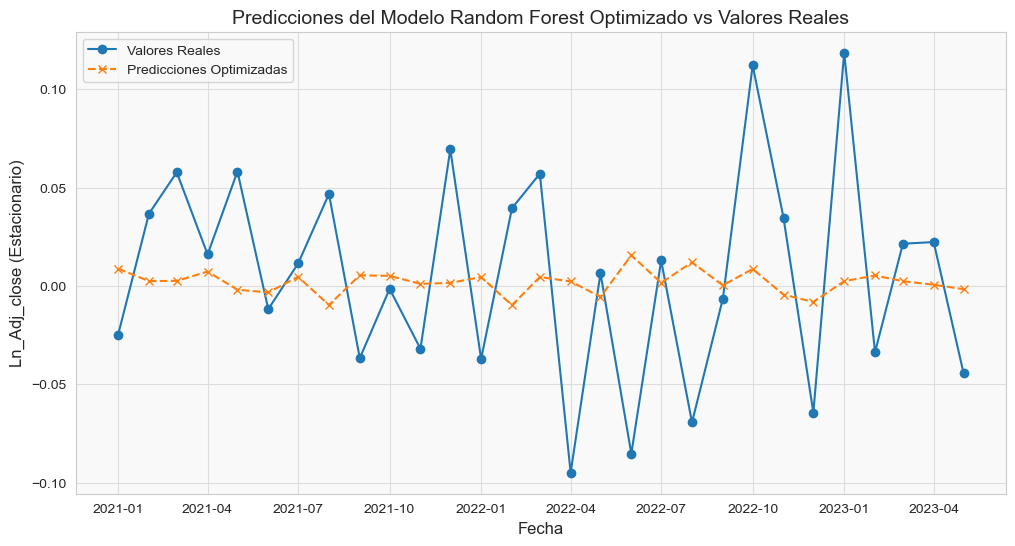

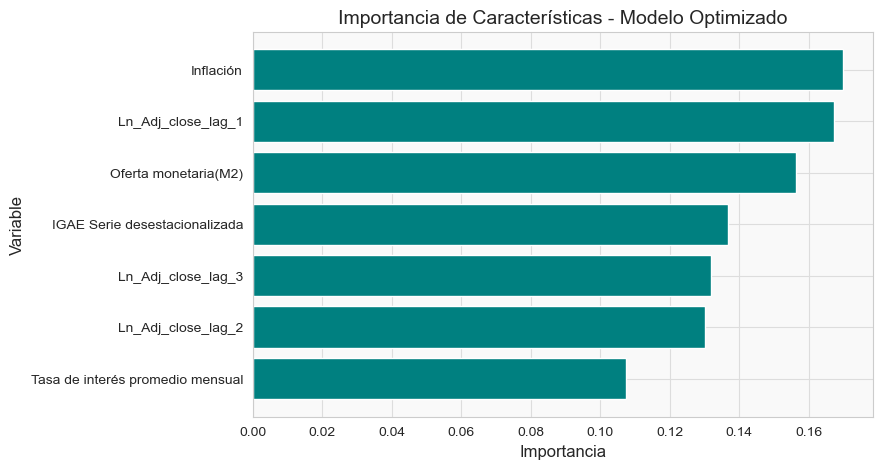

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 
# Hacemos una copia para no modificar el df original
df_rf = df_estacionario.copy()

# Añadimos lags de la variable objetivo (ln_ipc) como nuevas características predictoras
n_lags = 3
for i in range(1, n_lags + 1):
    df_rf[f'Ln_Adj_close_lag_{i}'] = df_rf['Ln_Adj_close'].shift(i)

# Eliminamos los NaNs creados por los rezagos
df_rf.dropna(inplace=True)

#  Definición de Variables y División de Datos ---
# 'X' ahora incluye las variables macro y los rezagos del IPC
X_rf = df_rf.drop(columns=['Ln_Adj_close'])
y_rf = df_rf['Ln_Adj_close']

# Dividimos en entrenamiento y prueba (80% - 20%) para la evaluación FINAL
split_index = int(len(df_rf) * 0.8)
X_train, X_test = X_rf.iloc[:split_index], X_rf.iloc[split_index:]
y_train, y_test = y_rf.iloc[:split_index], y_rf.iloc[split_index:]

#  Búsqueda de Hiperparámetros con Validación Cruzada ---
print("--- Iniciando búsqueda de hiperparámetros con GridSearchCV ---")

# Definimos los parámetros que queremos probar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_leaf': [3, 5],
    'max_features': ['sqrt', 0.5]
}

# Creamos el objeto de validación cruzada para series de tiempo
tscv = TimeSeriesSplit(n_splits=5)

# Creamos el modelo base
rf = RandomForestRegressor(random_state=12345, n_jobs=-1)

# Creamos el objeto GridSearchCV
# cv=tscv es crucial para que la validación respete el orden del tiempo
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=tscv, n_jobs=-1, verbose=1, 
                           scoring='neg_root_mean_squared_error')

# Ejecutamos la búsqueda en el CONJUNTO DE ENTRENAMIENTO
grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo y sus parámetros
print(f"\nMejores parámetros encontrados: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_

# --Evaluación del Modelo Optimizado ---
# Hacemos predicciones en el conjunto de prueba con el modelo mejorado
y_pred = best_rf_model.predict(X_test)

# Métricas de evaluación
train_score = best_rf_model.score(X_train, y_train)
test_score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n--- Evaluación del Modelo Random Forest OPTIMIZADO ---")
print(f"Puntaje R² en entrenamiento: {train_score:.4f}")
print(f"Puntaje R² en prueba: {test_score:.4f}")
print(f"RMSE en prueba: {rmse:.4f}")
print(f"MAE en prueba: {mae:.4f}")

# -Visualización de Resultados ---
# Gráfico de predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Valores Reales', marker='o', linestyle='-')
plt.plot(y_test.index, y_pred, label='Predicciones Optimizadas', marker='x', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Ln_Adj_close (Estacionario)')
plt.title('Predicciones del Modelo Random Forest Optimizado vs Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de importancia de características del modelo optimizado
df_importancia = pd.DataFrame({
    'Variable': X_rf.columns,
    'Importancia': best_rf_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(df_importancia['Variable'], df_importancia['Importancia'], color='teal')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de Características - Modelo Optimizado')
plt.gca().invert_yaxis()
plt.show()

#### *La dirección  selectiva del Modelo Autorregresivo de Rezagos Distribuidos (oferta monetaria) es consistente con el ordenamiento de impotancia de las variables macroeconómicas en términos explicativos en ambos algoritmos propios del machine learning*

### 3. Análisis con Redes neuronales

A continuación se usará un modelo llamado LSTM (Long Short-Term Memory) el entrenamiento de este modelo le da un giro importante a esta investigación dada la relevacia dinámica que se halló entre las variables, y propongo el uso del LSTM, ya que su arquitectura introduce un mecanismo para decidir qué información guardar, cuál olvidar y qué información usar para la predicción.

Construyendo y entrenando el modelo LSTM...
Epoch 1/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0337
Epoch 2/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0173
Epoch 3/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0173
Epoch 4/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0137
Epoch 5/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0137
Epoch 6/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0113
Epoch 7/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0121
Epoch 8/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0123
Epoch 9/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0103
Epoch 10/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0089
Epoch 11/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0097
Epoch 12/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088
Epoch 13/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081
Epoch 14/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086
Epoc

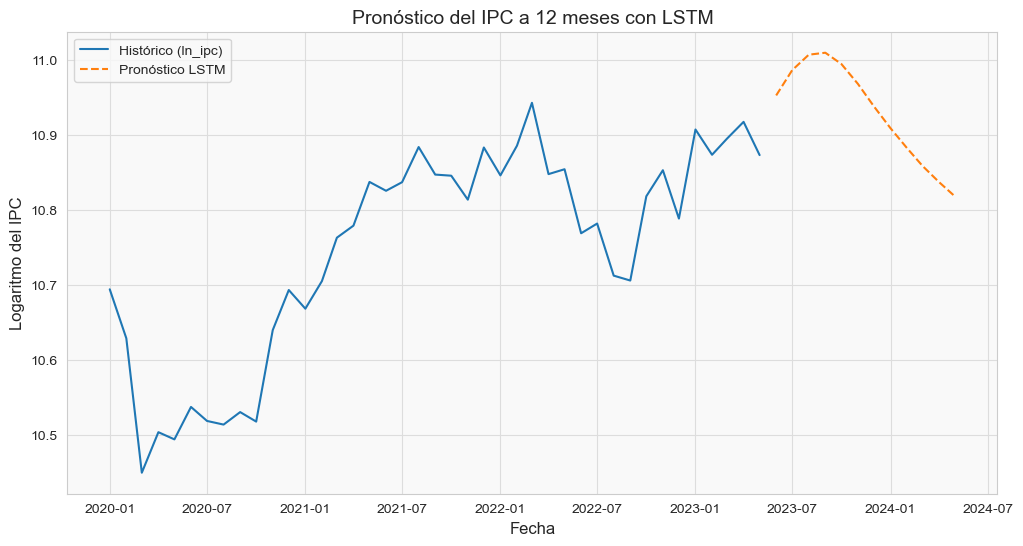

In [ ]:
# Contrucción del modelo LSTM (Long Short-Term Memory) para predecir el IPC



try:
    # --- 1. Carga y Preparación de Datos ---
    df_acotado = data[['Ln_Adj_close', 'Tasa de interés promedio mensual', 'IGAE Serie desestacionalizada', 'Oferta monetaria(M2)', 'Inflación']].copy()
    df_acotado.rename(columns={'Ln_Adj_close': 'ln_ipc', 'Tasa de interés promedio mensual': 'tasa_interes', 'IGAE Serie desestacionalizada': 'igae', 'Oferta monetaria(M2)': 'm2', 'Inflación': 'inflacion'}, inplace=True)
    df_acotado['tasa_interes'] = df_acotado['tasa_interes'].rolling(window=12).mean()
    df_acotado.dropna(inplace=True)

    # --- 2. Escalar los Datos ---
    # Las redes neuronales funcionan mejor con datos normalizados (entre 0 y 1).
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df_acotado)
    
    # Se crea un scaler separado solo para la variable objetivo (ln_ipc) para poder revertir el pronóstico fácilmente.
    scaler_ipc = MinMaxScaler(feature_range=(0, 1))
    scaler_ipc.fit_transform(df_acotado[['ln_ipc']])

    # --- 3. Creación de Secuencias de Tiempo ---
    # El LSTM mirará una ventana de 'n_steps' meses hacia atrás para predecir el siguiente.
    n_steps = 12
    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i-n_steps:i, :]) # Todas las variables como features
        y.append(scaled_data[i, 0])          # La primera columna (ln_ipc) como objetivo

    X, y = np.array(X), np.array(y)

    # --- 4. Construcción del Modelo LSTM ---
    print("Construyendo y entrenando el modelo LSTM...")
    modelo_lstm = Sequential()
    modelo_lstm.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    modelo_lstm.add(LSTM(50, return_sequences=False))
    modelo_lstm.add(Dense(25))
    modelo_lstm.add(Dense(1))

    # Compila el modelo especificando el optimizador y la función de pérdida.
    modelo_lstm.compile(optimizer='adam', loss='mean_squared_error')

    # --- 5. Entrenamiento del Modelo ---
    # Se ajusta el modelo a los datos. 'epochs' es el número de veces que la red verá todos los datos.
    modelo_lstm.fit(X, y, batch_size=1, epochs=25, verbose=1)

    # --- 6. Pronóstico Iterativo a 12 meses ---
    n_forecast = 12
    # Toma la última secuencia de datos conocidos para empezar a predecir.
    ultimos_pasos = X[-1].reshape(1, n_steps, X.shape[2])
    pronostico_lstm_scaled = []

    for _ in range(n_forecast):
        # Predice el siguiente paso (la predicción estará escalada).
        prediccion_scaled = modelo_lstm.predict(ultimos_pasos)[0][0]
        pronostico_lstm_scaled.append(prediccion_scaled)
        
        # Actualiza la secuencia de entrada para la siguiente predicción.
        nuevo_paso = np.roll(ultimos_pasos, -1, axis=1)
        nuevo_paso[0, -1, 0] = prediccion_scaled # Actualiza el valor del IPC con la nueva predicción.
        # Mantiene las otras variables constantes con su último valor conocido.
        for i in range(1, X.shape[2]):
            nuevo_paso[0, -1, i] = ultimos_pasos[0, -1, i]
        
        ultimos_pasos = nuevo_paso

    # --- 7. Revertir el Escalamiento del Pronóstico ---
    # Se usa el scaler del IPC para convertir el pronóstico a su escala original.
    pronostico_lstm = scaler_ipc.inverse_transform(np.array(pronostico_lstm_scaled).reshape(-1, 1))

    # --- 8. Visualización ---
    indice_pronostico = pd.date_range(start=df_acotado.index[-1], periods=n_forecast + 1, freq='MS')[1:]
    pronostico_lstm_series = pd.Series(pronostico_lstm.flatten(), index=indice_pronostico)

    plt.figure(figsize=(12, 6))
    plt.plot(df_acotado['ln_ipc']['2020':], label='Histórico (ln_ipc)')
    plt.plot(pronostico_lstm_series, label='Pronóstico LSTM', linestyle='--')
    plt.title('Pronóstico del IPC a 12 meses con LSTM')
    plt.xlabel('Fecha')
    plt.ylabel('Logaritmo del IPC')
    plt.legend()
    plt.grid(True)
    plt.savefig('pronostico_lstm.png')
    print("\nGráfico 'pronostico_lstm.png' guardado con éxito.")

except Exception as e:
    print(f"\nOcurrió un error: {e}")
    print("Es posible que necesites instalar la librería 'tensorflow'. Prueba con: pip install tensorflow")

**Evaluación del modelo**

Datos de entrenamiento: 120 observaciones
Datos de prueba: 30 observaciones

Entrenando Modelo LSTM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step

--- Métricas de Desempeño del Modelo LSTM (sobre datos de prueba) ---
Error Absoluto Medio (MAE): 0.0575
Raíz del Error Cuadrático Medio (RMSE): 0.0664


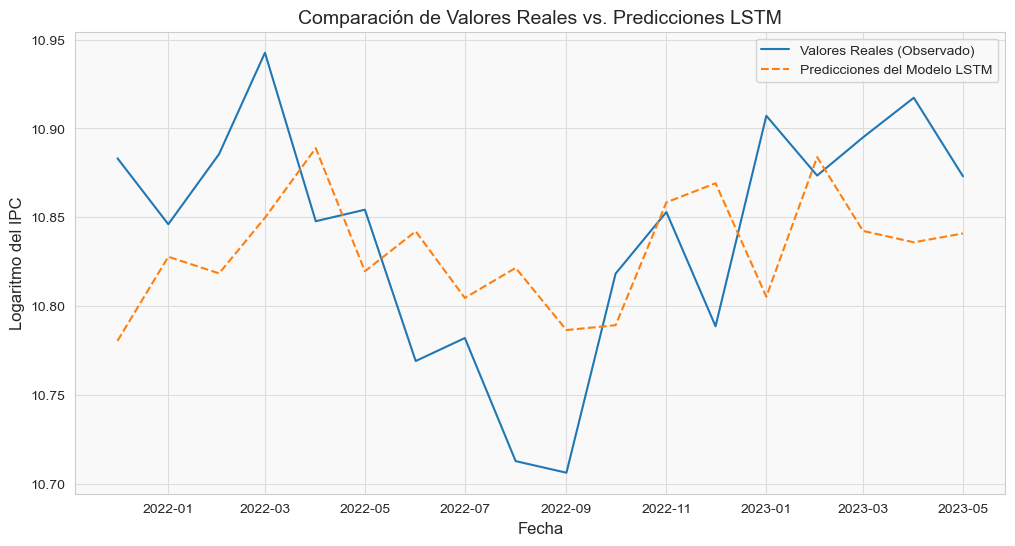

In [27]:

try:
    
    # ---  División de Datos en Entrenamiento y Prueba (Cronológica) ---
    # Usaremos el 80% para entrenar y el 20% final para probar.
    train_size = int(len(df_acotado) * 0.8)
    train_df, test_df = df_acotado.iloc[:train_size], df_acotado.iloc[train_size:]

    print(f"Datos de entrenamiento: {len(train_df)} observaciones")
    print(f"Datos de prueba: {len(test_df)} observaciones")

    # ---  Escalamiento de Datos ---
    # Se ajusta el scaler SÓLO con los datos de entrenamiento para evitar fuga de información.
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_df)
    
    # Se transforman ambos conjuntos de datos con el scaler ya ajustado.
    train_scaled = scaler.transform(train_df)
    test_scaled = scaler.transform(test_df)
    
    # Scaler separado para la variable objetivo (ln_ipc) para revertir la predicción.
    scaler_ipc = MinMaxScaler(feature_range=(0, 1))
    scaler_ipc.fit(train_df[['ln_ipc']])

    # ---  Creación de Secuencias de Tiempo ---
    def crear_secuencias(data, n_steps=12):
        X, y = [], []
        for i in range(n_steps, len(data)):
            X.append(data[i-n_steps:i, :])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    n_steps = 12
    X_train, y_train = crear_secuencias(train_scaled, n_steps)
    X_test, y_test = crear_secuencias(test_scaled, n_steps)

    # ---  Construcción y Entrenamiento del Modelo LSTM ---
    modelo_lstm = Sequential()
    modelo_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    modelo_lstm.add(LSTM(50, return_sequences=False))
    modelo_lstm.add(Dense(25))
    modelo_lstm.add(Dense(1))
    modelo_lstm.compile(optimizer='adam', loss='mean_squared_error')

    print("\nEntrenando Modelo LSTM...")
    modelo_lstm.fit(X_train, y_train, batch_size=1, epochs=25, verbose=0)

    # ---  Predicción y Cálculo de Métricas ---
    # Realiza predicciones sobre el conjunto de prueba.
    y_pred_scaled = modelo_lstm.predict(X_test)
    
    # Revertimiento el escalamiento de las predicciones y de los valores reales para poder compararlos.
    y_pred = scaler_ipc.inverse_transform(y_pred_scaled)
    y_test_orig = scaler_ipc.inverse_transform(y_test.reshape(-1, 1))

    # Calculo de las métricas con los valores en su escala original.
    mae = mean_absolute_error(y_test_orig, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))

    print("\n--- Métricas de Desempeño del Modelo LSTM (sobre datos de prueba) ---")
    print(f"Error Absoluto Medio (MAE): {mae:.4f}")
    print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")

    # --- Visualización ---
    # Se utiliza el índice del DataFrame de prueba, ajustando por el tamaño de la secuencia.
    index_test = test_df.index[n_steps:]
    
    plt.figure(figsize=(12, 6))
    plt.plot(index_test, y_test_orig, label='Valores Reales (Observado)')
    plt.plot(index_test, y_pred, label='Predicciones del Modelo LSTM', linestyle='--')
    plt.title('Comparación de Valores Reales vs. Predicciones LSTM')
    plt.xlabel('Fecha')
    plt.ylabel('Logaritmo del IPC')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"\nOcurrió un error: {e}")

#### Mejora del modelo de aprendizaje profundo, con validación cruzada

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings("ignore")

try:
    
    
    df_acotado = data[['Ln_Adj_close', 'Tasa de interés promedio mensual', 'IGAE Serie desestacionalizada', 'Oferta monetaria(M2)', 'Inflación']].copy()
    df_acotado.rename(columns={'Ln_Adj_close': 'ln_ipc', 'Tasa de interés promedio mensual': 'tasa_interes', 'IGAE Serie desestacionalizada': 'igae', 'Oferta monetaria(M2)': 'm2', 'Inflación': 'inflacion'}, inplace=True)
    df_acotado['tasa_interes'] = df_acotado['tasa_interes'].rolling(window=12).mean()
    df_acotado.dropna(inplace=True)

    # - Escalamiento y creación de secuencias  ---
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df_acotado)
    scaler_ipc = MinMaxScaler(feature_range=(0, 1))
    scaler_ipc.fit(df_acotado[['ln_ipc']])

    n_steps = 12
    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i-n_steps:i, :])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)

    # --Validación Cruzada para Series de Tiempo ---
    n_splits = 5  # Número de pliegues (folds)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    scores_rmse = [] # Lista para guardar el error de cada fold

    print(f"Iniciando validación cruzada con {n_splits} folds...")

    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")
        
        # Separar datos para este fold
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # --- Construcción del Modelo LSTM (se recrea en cada fold) ---
        # Se añade Dropout y EarlyStopping para combatir el sobreajuste
        modelo_lstm = Sequential()
        modelo_lstm.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
        modelo_lstm.add(Dropout(0.2)) # Capa de Dropout
        modelo_lstm.add(LSTM(50, return_sequences=False))
        modelo_lstm.add(Dropout(0.2)) # Capa de Dropout
        modelo_lstm.add(Dense(25))
        modelo_lstm.add(Dense(1))
        
        modelo_lstm.compile(optimizer='adam', loss='mean_squared_error')
        
        # Early stopping para detener el entrenamiento si no hay mejora
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # - Entrenamiento del Modelo para este Fold ---
        print("Entrenando...")
        modelo_lstm.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=50, # Aumentamos epochs, EarlyStopping decidirá cuándo parar
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        verbose=0) # verbose=0 para una salida más limpia

        # - Evaluación del Fold ---
        print("Evaluando...")
        y_pred_scaled = modelo_lstm.predict(X_val)
        
        # Revertir el escalamiento para calcular el error en la escala original
        y_pred = scaler_ipc.inverse_transform(y_pred_scaled)
        y_val_orig = scaler_ipc.inverse_transform(y_val.reshape(-1, 1))

        # Calcular y guardar el RMSE del fold
        rmse = np.sqrt(mean_squared_error(y_val_orig, y_pred))
        scores_rmse.append(rmse)
        print(f"RMSE del Fold {fold+1}: {rmse:.4f}")

    # -- Resultados Finales de la Validación Cruzada ---
    print("\n--- Resultados de la Validación Cruzada ---")
    print(f"Scores RMSE de cada fold: {[round(score, 4) for score in scores_rmse]}")
    print(f"RMSE Promedio: {np.mean(scores_rmse):.4f}")
    print(f"Desviación Estándar del RMSE: {np.std(scores_rmse):.4f}")

except FileNotFoundError:
    print("\nError: No se encontró el archivo 'variables limpias .xlsx'.")
except Exception as e:
    print(f"\nOcurrió un error: {e}")

Iniciando validación cruzada con 5 folds...

--- Fold 1/5 ---
Entrenando...
Evaluando...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
RMSE del Fold 1: 0.0379

--- Fold 2/5 ---
Entrenando...
Evaluando...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
RMSE del Fold 2: 0.0341

--- Fold 3/5 ---
Entrenando...
Evaluando...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
RMSE del Fold 3: 0.0655

--- Fold 4/5 ---
Entrenando...
Evaluando...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
RMSE del Fold 4: 0.0963

--- Fold 5/5 ---
Entrenando...
Evaluando...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
RMSE del Fold 5: 0.0713

--- Resultados de la Validación Cruzada ---
Scores RMSE de cada fold: [np.float64(0.0379), np.float64(0.0341), np.float64(0.0655), np.float64(0.0963), np.float64(0.0713)]
RMSE Promedio: 0.0610
Desviación Estándar del RMSE: 0.0229


Entrenando el modelo final con todos los datos disponibles...
Epoch 1/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0448
Epoch 2/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0221
Epoch 3/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0201
Epoch 4/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0184
Epoch 5/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0175
Epoch 6/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0136
Epoch 7/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0158
Epoch 8/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0142
Epoch 9/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0135
Epoch 10/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0144
Epoch 11/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0135
Epoch 12/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0107
Epoch 13/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0133
Epoch 14/25
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/s

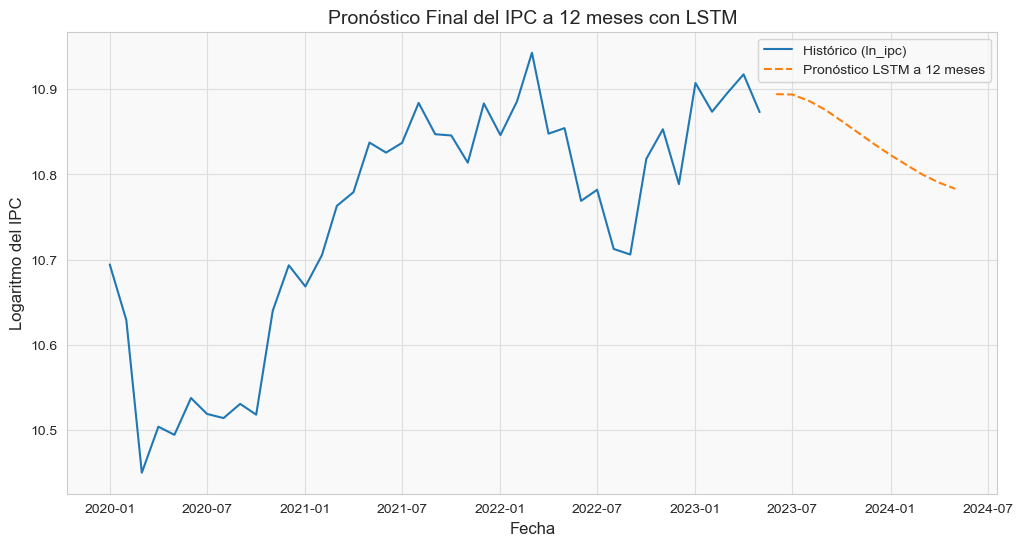

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings

warnings.filterwarnings("ignore")

try:
    
    
    df_acotado = data[['Ln_Adj_close', 'Tasa de interés promedio mensual', 'IGAE Serie desestacionalizada', 'Oferta monetaria(M2)', 'Inflación']].copy()
    df_acotado.rename(columns={'Ln_Adj_close': 'ln_ipc', 'Tasa de interés promedio mensual': 'tasa_interes', 'IGAE Serie desestacionalizada': 'igae', 'Oferta monetaria(M2)': 'm2', 'Inflación': 'inflacion'}, inplace=True)
    df_acotado['tasa_interes'] = df_acotado['tasa_interes'].rolling(window=12).mean()
    df_acotado.dropna(inplace=True)

    # - Escalar y Crear Secuencias con TODOS los datos ---
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df_acotado)
    scaler_ipc = MinMaxScaler(feature_range=(0, 1))
    scaler_ipc.fit(df_acotado[['ln_ipc']])

    n_steps = 12
    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i-n_steps:i, :])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)

    # . Construcción del Modelo LSTM Final ---
    # Usamos la arquitectura mejorada con Dropout
    modelo_final_lstm = Sequential()
    modelo_final_lstm.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    modelo_final_lstm.add(Dropout(0.2))
    modelo_final_lstm.add(LSTM(50, return_sequences=False))
    modelo_final_lstm.add(Dropout(0.2))
    modelo_final_lstm.add(Dense(25))
    modelo_final_lstm.add(Dense(1))
    
    modelo_final_lstm.compile(optimizer='adam', loss='mean_squared_error')

    #  Entrenamiento del Modelo Final con TODOS los datos ---
    print("Entrenando el modelo final con todos los datos disponibles...")
    modelo_final_lstm.fit(X, y, batch_size=1, epochs=25, verbose=1)

    #  Pronóstico Iterativo a 12 meses ---
    n_forecast = 12
    ultimos_pasos = X[-1].reshape(1, n_steps, X.shape[2])
    pronostico_lstm_scaled = []

    print("\nGenerando pronóstico a 12 meses...")
    for _ in range(n_forecast):
        prediccion_scaled = modelo_final_lstm.predict(ultimos_pasos, verbose=0)[0][0]
        pronostico_lstm_scaled.append(prediccion_scaled)
        
        nuevo_paso = np.roll(ultimos_pasos, -1, axis=1)
        nuevo_paso[0, -1, 0] = prediccion_scaled
        for i in range(1, X.shape[2]):
            nuevo_paso[0, -1, i] = ultimos_pasos[0, -1, i]
        
        ultimos_pasos = nuevo_paso

    # --Revertimos el Escalamiento del Pronóstico ---
    pronostico_lstm = scaler_ipc.inverse_transform(np.array(pronostico_lstm_scaled).reshape(-1, 1))

    # -- Visualización del Pronóstico Final ---
    indice_pronostico = pd.date_range(start=df_acotado.index[-1], periods=n_forecast + 1, freq='MS')[1:]
    pronostico_lstm_series = pd.Series(pronostico_lstm.flatten(), index=indice_pronostico)

    plt.figure(figsize=(12, 6))
    plt.plot(df_acotado['ln_ipc']['2020':], label='Histórico (ln_ipc)')
    plt.plot(pronostico_lstm_series, label='Pronóstico LSTM a 12 meses', linestyle='--')
    plt.title('Pronóstico Final del IPC a 12 meses con LSTM')
    plt.xlabel('Fecha')
    plt.ylabel('Logaritmo del IPC')
    plt.legend()
    plt.grid(True)
    plt.savefig('pronostico_final_lstm.png')
    print("\nGráfico 'pronostico_final_lstm.png' guardado con éxito.")

except FileNotFoundError:
    print("\nError: No se encontró el archivo 'variables limpias .xlsx'.")
except Exception as e:
    print(f"\nOcurrió un error: {e}")

### Resumen de los hallazgos 

Este trabajo de investigación naturalmente busca el modelo óptimo para el comportamiento del IPC bajo un análisis comparativo entre modelos econométricos y modelos pertenecientes a la ciencia de datos. 

Siguiendo la narrativa de datos que corresponde a los resultados obtenidos, el modelo ARIMA (0,1,0) fue seleccionado como el más parsimonioso y con el mejor ajuste estadístico (AIC de -519.459). Este modelo, corresponde a una caminata aleatoria con deriva, sugiere que la mejor predicción para el IPC futuro es su valor actual más una tendencia constante, como se modelo en la parte del análisis correspondiente a este modelo. Este resultado respalda la Hipótesis del Mercado Eficiente en el sentido de que los movimientos del mercado son estocásticos y no pueden ser pronosticados consistentemente a partir de su propia historia, en el gráfico 6, se ve la tendencia con pendiente positiva existente, comportamiento que se corrobora en el comportamiento real del Índice de Precios y Cotizaciones hasta septiembre 2025.

Posteriormente, se siguió el análisis en aras de complementar el resultado obtenido con el modelo ARIMA (0,1,0) con un modelo autorregresivo de rezagos distribuidos, y se encontró que la oferta monetaria tiene una relación a largo plazo estadísticamente significativa en el corto plazo. Luego se replanteó el análisis, pensado en el largo plazo y se encontró que el comportamiento del IPC tiene un sustento macroeconómico en su mayoría, y que bajo este análisis, se tiene una velocidad de ajuste mensual del 26.6% al mes, en términos regreso al equilibrio, y que, como se mencionó anteriormente, los agentes económicos tenemos la ventaja en términos de consulta de información para hacer decisiones financieras.

Ahora, bajo la hipótesis de que las relaciones entre las variables macroeconómicas y el comportamiento del índice de precios y cotizaciones, podría tener una dinámica no lineal, se usaron modelos propios del machine learning y el aprendizaje profundo. Y aunque se identificó y validó el resultado del modelo autorregresivo de rezagos distribuidos, en el sentido de que la oferta monetaria es la variable más importante en relación con el IPC, estos modelos tuvieron un severo sobreajuste, a pesar de que se hizo la optimización propia y métodos de validación pertinentes (en los cuales se añadieron rezagos del logaritmo del precio de cierre ajustado del IPC, dentro del modelo XG Boost). Este resultado demuestra, que a pesar de que los modelos de machine learning tienen una gran capacidad para aprender patrones complejos, estos no lograron hacer una buena predicción del IPC. 

Finalmente, se entrenó un modelo LSTM (tanto en su versión optimizada, como en la primer versión), y la red neuronal predijo una tendencia bajista, mientras en la realidad sucedió lo contrario. Económicamente, esto sugiere que la red neuronal identificó un patrón complejo en la configuración de las variables macroeconómicas que, basado en la historia, señalaba una posible corrección del mercado, un tipo de advertencia que los otros modelos no pudieron generar.

Entonces: 

•	El modelo autorregresivo de rezagos distribuidos confirma una relación de equilibrio a largo plazo con fundamentos macroeconómicos.

•	Los modelos de machine learning fallan en la predicción de los movimientos de corto plazo, ya que en el conjunto de prueba (con datos no vistos) es donde el modelo falló obteniendo un R2  de -0.0660 para Random Forest y -0.1454 para XGBoost, es decir, que estos modelos se quedaron sin poder predictivo.  Lo que nos dice que los modelos complejos no funcionan correctamente para ser usados en el corto plazo.

•	El Modelo ARIMA resultó un modelo acertado para la predicción del IPC, y el modelo autorregresivo de rezagos distribuidos fue contundente en las predicciones. Lo que deja claro que el uso del modelado econométrico, por su precisión y metodología aún es superior a los modelos propios de la ciencia de datos que se utilizaron.



### Obervaciones y posibles mejoras en función de los resultados obtenidos

Referente a las recomendaciones y observaciones:

1.	A lo largo de este documento se demostró que la aplicación de algoritmos propios del machine learning se tiene que usar con cuidado, dado su desempeño, esto puede llevar a interpretaciones erróneas de la dinámica del mercado, y, por consiguiente, a decisiones sesgadas. La recomendación para los analistas interesados es usar ambas perspectivas, y usar el criterio económico para tomar decisiones basadas en datos.

2.	Modelar la volatilidad del IPC a través de un modelo GARCH.

3.	En la medida de lo posible, usar modelos híbridos. 

4.	Se podría aprovechar el poder predictivo de los modelos de machine learning usando un intervalo más amplio, y más variables macroeconómicas, haciendo más rico el análisis, o bien para darle continuidad a la predicción que hace el modelo ARIMA, es decir, hacer el trabajo predictivo a un año con el modelo ARIMA, y a partir de ahí seguir el análisis con los modelos de machine learning y de aprendizaje profundo.


### Bibliografía

•	Boschetti, A., & Massaron, L. (2023). Python data science essentials (3rd ed.). Packt Publishing.

•	Brownlee, J. (2018). Deep Learning for Time Series Forecasting: Predict the Future with MLPs, CNNs and LSTMs in Python. Machine Learning Mastery.

•	Engle, R. F., & Granger, C. W. J. (1987). Co-integration and error correction: Representation, estimation, and testing. Econometrica, 55(2), 251–276.

•	Fama, E. F. (1970). Efficient capital markets: A review of theory and empirical work. The Journal of Finance, 25(2), 383–417.

•	Gers, F. A., Schmidhuber, J., & Cummins, F. (2000). Learning to Forget: Continual Prediction with LSTM. Neural Computation, 12(10), 2451–2471.

•	Gujarati, D. N., & Porter, D. C. (2010). Econometría (5ª ed.). McGraw-Hill.

•	Henrique, B. M., Sobreiro, V. A., & Kimura, H. (2019). Literature review: Machine learning techniques applied to financial market prediction. Expert Systems with Applications, 124, 226–251.

•	Hernández Mota, J. L. (2015). El papel del desarrollo financiero como fuente del crecimiento económico. Revista finanzas y política económica, 7(2), 235–256. https://doi.org/10.14718/revfinanzpolitecon.2015.7.2.2

•	Hernández Sampieri, R., Fernández Collado, C., & Baptista Lucio, P. (2014). Metodología de la investigación (6ª ed.). McGraw-Hill.

•	Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. Neural Computation, 9(8), 1735–1780.

•	McMillan, D. G. (2001). Non-linear predictability of UK stock market returns. Oxford Bulletin of Economics and Statistics, 63(5), 639–657.

•	Nkoro, E., & Uko, A. K. (2016). Autoregressive Distributed Lag (ARDL) cointegration technique: application and interpretation. Journal of Statistical and Econometric Methods, 5, 1–3. https://www.scienpress.com/Upload/JSEM/Vol%205_4_3.pdf

•	Scikit-learn developers. (2025). Supervised learning. En Scikit-learn 1.7.2 Documentation: https://scikit-learn.org/stable/supervised_learning.html

•	Tobin, J. (1969). A general equilibrium approach to monetary theory. Journal of Money, Credit and Banking, 1(1), 15–29.

•	VanderPlas, J. (2016). Python data science handbook: Essential tools for working with data. O’Reilly Media.

